In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import spacy
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec, Phrases

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, confusion_matrix

Using TensorFlow backend.


In [2]:
df  = pd.read_csv("consumer_reviews.csv")

In [3]:
data = df.reviews.values.tolist()

In [4]:
# Removes puncuations
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

In [5]:
# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

In [7]:
# Creating Bi-gram Object
bigram = gensim.models.Phrases(data_words, min_count=5)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [8]:
# Removing Stopwords  , Bigrams , Lemmatize noun,adj,verb,adverb
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove StopWords
stop_words = stopwords.words('english')
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# POS Tagger
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Creating Word Vector Using Word2Vec
embedding_vector_size = 256
bigrams_model = Word2Vec(sentences = data_lemmatized,size = embedding_vector_size,min_count=3, window=5, workers=4)

In [12]:
print("Vocabulary size:", len(bigrams_model.wv.vocab))

Vocabulary size: 4895


In [14]:
def vectorize_data(data, vocab: dict) -> list:
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    return vectorized

In [15]:
# Padding Input Shape according to Neural Network
X_data = bigram_mod[data_lemmatized]
input_length = 300
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=bigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')

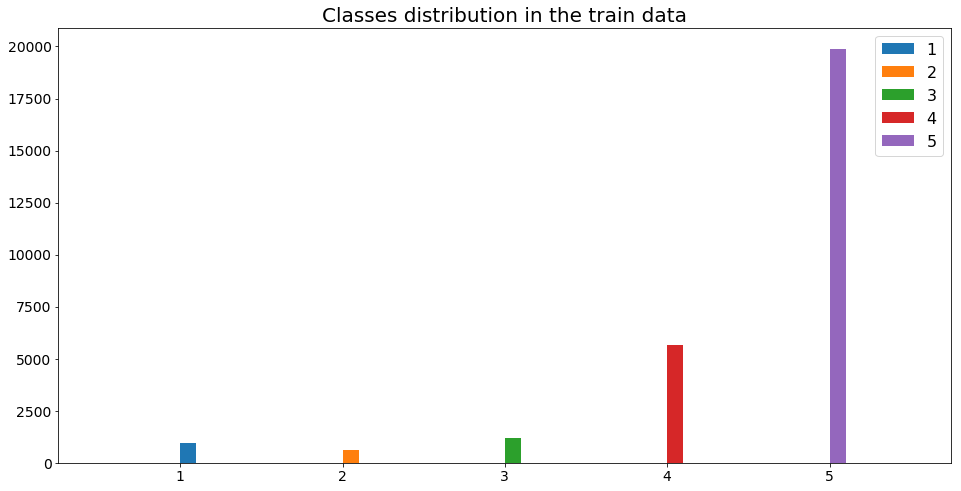

In [20]:
params = {'figure.figsize': (16, 8),}
plt.rcParams.update(params)
plt.hist(df[df.rating == 1].rating, label='1')
plt.hist(df[df.rating == 2].rating,label='2')
plt.hist(df[df.rating == 3].rating,label='3')
plt.hist(df[df.rating == 4].rating,label='4')
plt.hist(df[df.rating == 5].rating,label='5')
plt.title('Classes distribution in the train data', fontsize=20)
plt.legend()
plt.show()

In [23]:
# As Data UnBalanced we Take Less then 5 as Negative
ratings = list()
for x in df.rating:
    if x < 5:
        ratings.append(0)
    else :
        ratings.append(1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    ratings,
    test_size=0.05,
    shuffle=True,
    random_state=42)

In [25]:
# Create Neural Network with Embedding Input layer
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0],output_dim = embedding_matrix.shape[1], 
        input_length = input_length,weights = [embedding_matrix],trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model
model = build_model(embedding_matrix=bigrams_model.wv.vectors,input_length=input_length)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          1253120   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)      

In [29]:
neural = model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'],)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=60 )

Train on 26915 samples, validate on 1417 samples
Epoch 1/60


20300/26915 [=====================>........] - ETA: 18:37 - loss: 0.5821 - acc: 0.71 - ETA: 11:29 - loss: 0.6499 - acc: 0.65 - ETA: 9:09 - loss: 0.6356 - acc: 0.6700 - ETA: 7:51 - loss: 0.6231 - acc: 0.672 - ETA: 7:08 - loss: 0.6216 - acc: 0.674 - ETA: 6:40 - loss: 0.6122 - acc: 0.683 - ETA: 6:18 - loss: 0.6098 - acc: 0.690 - ETA: 6:04 - loss: 0.6051 - acc: 0.693 - ETA: 5:50 - loss: 0.6032 - acc: 0.697 - ETA: 5:38 - loss: 0.6048 - acc: 0.699 - ETA: 5:30 - loss: 0.6138 - acc: 0.691 - ETA: 5:22 - loss: 0.6090 - acc: 0.695 - ETA: 5:17 - loss: 0.6034 - acc: 0.699 - ETA: 5:12 - loss: 0.6014 - acc: 0.701 - ETA: 5:12 - loss: 0.6026 - acc: 0.701 - ETA: 5:07 - loss: 0.6062 - acc: 0.696 - ETA: 5:02 - loss: 0.6088 - acc: 0.692 - ETA: 4:58 - loss: 0.6072 - acc: 0.695 - ETA: 4:57 - loss: 0.6067 - acc: 0.695 - ETA: 4:54 - loss: 0.6047 - acc: 0.697 - ETA: 4:54 - loss: 0.6067 - acc: 0.693 - ETA: 4:52 - loss: 0.6063 - acc: 0.694 - ETA: 4:50 - loss: 0.6055 - acc: 0.696 - ETA: 4:47 - loss: 0.6049 - acc: 

26915/26915 [==============================] - ETA: 1:07 - loss: 0.5882 - acc: 0.704 - ETA: 1:06 - loss: 0.5882 - acc: 0.704 - ETA: 1:05 - loss: 0.5886 - acc: 0.703 - ETA: 1:04 - loss: 0.5880 - acc: 0.704 - ETA: 1:03 - loss: 0.5876 - acc: 0.705 - ETA: 1:02 - loss: 0.5878 - acc: 0.704 - ETA: 1:00 - loss: 0.5879 - acc: 0.704 - ETA: 59s - loss: 0.5875 - acc: 0.705 - ETA: 58s - loss: 0.5872 - acc: 0.70 - ETA: 57s - loss: 0.5874 - acc: 0.70 - ETA: 56s - loss: 0.5874 - acc: 0.70 - ETA: 55s - loss: 0.5876 - acc: 0.70 - ETA: 54s - loss: 0.5875 - acc: 0.70 - ETA: 53s - loss: 0.5873 - acc: 0.70 - ETA: 52s - loss: 0.5875 - acc: 0.70 - ETA: 51s - loss: 0.5873 - acc: 0.70 - ETA: 50s - loss: 0.5877 - acc: 0.70 - ETA: 49s - loss: 0.5877 - acc: 0.70 - ETA: 48s - loss: 0.5877 - acc: 0.70 - ETA: 47s - loss: 0.5877 - acc: 0.70 - ETA: 46s - loss: 0.5878 - acc: 0.70 - ETA: 45s - loss: 0.5881 - acc: 0.70 - ETA: 44s - loss: 0.5880 - acc: 0.70 - ETA: 43s - loss: 0.5881 - acc: 0.70 - ETA: 42s - loss: 0.5884 - 

20400/26915 [=====================>........] - ETA: 4:24 - loss: 0.6324 - acc: 0.680 - ETA: 4:20 - loss: 0.5990 - acc: 0.700 - ETA: 4:16 - loss: 0.6032 - acc: 0.706 - ETA: 4:14 - loss: 0.6251 - acc: 0.685 - ETA: 4:12 - loss: 0.6035 - acc: 0.704 - ETA: 4:11 - loss: 0.5990 - acc: 0.706 - ETA: 4:10 - loss: 0.5985 - acc: 0.704 - ETA: 4:09 - loss: 0.5966 - acc: 0.705 - ETA: 4:07 - loss: 0.5931 - acc: 0.710 - ETA: 4:05 - loss: 0.5905 - acc: 0.710 - ETA: 4:05 - loss: 0.5955 - acc: 0.706 - ETA: 4:04 - loss: 0.5977 - acc: 0.702 - ETA: 4:02 - loss: 0.5940 - acc: 0.704 - ETA: 4:01 - loss: 0.5897 - acc: 0.710 - ETA: 4:01 - loss: 0.5878 - acc: 0.710 - ETA: 4:00 - loss: 0.5845 - acc: 0.714 - ETA: 3:59 - loss: 0.5843 - acc: 0.714 - ETA: 3:57 - loss: 0.5853 - acc: 0.713 - ETA: 3:56 - loss: 0.5818 - acc: 0.716 - ETA: 3:55 - loss: 0.5826 - acc: 0.716 - ETA: 3:54 - loss: 0.5820 - acc: 0.714 - ETA: 3:53 - loss: 0.5870 - acc: 0.710 - ETA: 3:53 - loss: 0.5884 - acc: 0.708 - ETA: 3:52 - loss: 0.5866 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.5783 - acc: 0.711 - ETA: 1:00 - loss: 0.5786 - acc: 0.711 - ETA: 59s - loss: 0.5783 - acc: 0.711 - ETA: 58s - loss: 0.5782 - acc: 0.71 - ETA: 57s - loss: 0.5782 - acc: 0.71 - ETA: 56s - loss: 0.5784 - acc: 0.71 - ETA: 55s - loss: 0.5785 - acc: 0.71 - ETA: 55s - loss: 0.5783 - acc: 0.71 - ETA: 54s - loss: 0.5787 - acc: 0.71 - ETA: 53s - loss: 0.5787 - acc: 0.71 - ETA: 52s - loss: 0.5789 - acc: 0.71 - ETA: 51s - loss: 0.5787 - acc: 0.71 - ETA: 50s - loss: 0.5791 - acc: 0.71 - ETA: 49s - loss: 0.5793 - acc: 0.71 - ETA: 48s - loss: 0.5794 - acc: 0.71 - ETA: 47s - loss: 0.5795 - acc: 0.70 - ETA: 46s - loss: 0.5797 - acc: 0.70 - ETA: 45s - loss: 0.5799 - acc: 0.70 - ETA: 44s - loss: 0.5800 - acc: 0.70 - ETA: 43s - loss: 0.5803 - acc: 0.70 - ETA: 42s - loss: 0.5802 - acc: 0.70 - ETA: 41s - loss: 0.5801 - acc: 0.70 - ETA: 40s - loss: 0.5804 - acc: 0.70 - ETA: 39s - loss: 0.5803 - acc: 0.70 - ETA: 38s - loss: 0.5804 - acc: 0.70 

20400/26915 [=====================>........] - ETA: 4:18 - loss: 0.5754 - acc: 0.710 - ETA: 4:10 - loss: 0.5811 - acc: 0.720 - ETA: 4:09 - loss: 0.5565 - acc: 0.736 - ETA: 4:09 - loss: 0.5461 - acc: 0.740 - ETA: 4:12 - loss: 0.5452 - acc: 0.748 - ETA: 4:14 - loss: 0.5372 - acc: 0.748 - ETA: 4:16 - loss: 0.5495 - acc: 0.742 - ETA: 4:14 - loss: 0.5533 - acc: 0.738 - ETA: 4:12 - loss: 0.5574 - acc: 0.733 - ETA: 4:10 - loss: 0.5672 - acc: 0.727 - ETA: 4:09 - loss: 0.5704 - acc: 0.725 - ETA: 4:07 - loss: 0.5708 - acc: 0.723 - ETA: 4:06 - loss: 0.5736 - acc: 0.721 - ETA: 4:05 - loss: 0.5736 - acc: 0.722 - ETA: 4:04 - loss: 0.5733 - acc: 0.722 - ETA: 4:04 - loss: 0.5735 - acc: 0.721 - ETA: 4:03 - loss: 0.5755 - acc: 0.717 - ETA: 4:02 - loss: 0.5748 - acc: 0.717 - ETA: 4:01 - loss: 0.5741 - acc: 0.717 - ETA: 4:00 - loss: 0.5737 - acc: 0.719 - ETA: 4:00 - loss: 0.5744 - acc: 0.719 - ETA: 3:59 - loss: 0.5740 - acc: 0.722 - ETA: 3:57 - loss: 0.5732 - acc: 0.723 - ETA: 3:56 - loss: 0.5734 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.5722 - acc: 0.716 - ETA: 1:00 - loss: 0.5720 - acc: 0.716 - ETA: 59s - loss: 0.5722 - acc: 0.716 - ETA: 58s - loss: 0.5721 - acc: 0.71 - ETA: 57s - loss: 0.5722 - acc: 0.71 - ETA: 56s - loss: 0.5720 - acc: 0.71 - ETA: 55s - loss: 0.5720 - acc: 0.71 - ETA: 54s - loss: 0.5719 - acc: 0.71 - ETA: 53s - loss: 0.5718 - acc: 0.71 - ETA: 53s - loss: 0.5720 - acc: 0.71 - ETA: 52s - loss: 0.5716 - acc: 0.71 - ETA: 51s - loss: 0.5712 - acc: 0.71 - ETA: 50s - loss: 0.5712 - acc: 0.71 - ETA: 49s - loss: 0.5710 - acc: 0.71 - ETA: 48s - loss: 0.5716 - acc: 0.71 - ETA: 47s - loss: 0.5716 - acc: 0.71 - ETA: 46s - loss: 0.5717 - acc: 0.71 - ETA: 45s - loss: 0.5718 - acc: 0.71 - ETA: 44s - loss: 0.5718 - acc: 0.71 - ETA: 43s - loss: 0.5718 - acc: 0.71 - ETA: 42s - loss: 0.5721 - acc: 0.71 - ETA: 41s - loss: 0.5723 - acc: 0.71 - ETA: 40s - loss: 0.5723 - acc: 0.71 - ETA: 39s - loss: 0.5721 - acc: 0.71 - ETA: 38s - loss: 0.5719 - acc: 0.71 

20400/26915 [=====================>........] - ETA: 4:12 - loss: 0.5692 - acc: 0.690 - ETA: 4:14 - loss: 0.5935 - acc: 0.695 - ETA: 4:16 - loss: 0.5798 - acc: 0.713 - ETA: 4:19 - loss: 0.5812 - acc: 0.702 - ETA: 4:18 - loss: 0.5770 - acc: 0.700 - ETA: 4:17 - loss: 0.5659 - acc: 0.715 - ETA: 4:14 - loss: 0.5725 - acc: 0.710 - ETA: 4:13 - loss: 0.5708 - acc: 0.716 - ETA: 4:12 - loss: 0.5692 - acc: 0.720 - ETA: 4:10 - loss: 0.5568 - acc: 0.730 - ETA: 4:09 - loss: 0.5568 - acc: 0.729 - ETA: 4:07 - loss: 0.5655 - acc: 0.723 - ETA: 4:06 - loss: 0.5618 - acc: 0.728 - ETA: 4:05 - loss: 0.5607 - acc: 0.728 - ETA: 4:04 - loss: 0.5587 - acc: 0.729 - ETA: 4:03 - loss: 0.5575 - acc: 0.728 - ETA: 4:02 - loss: 0.5611 - acc: 0.725 - ETA: 4:00 - loss: 0.5645 - acc: 0.722 - ETA: 3:59 - loss: 0.5649 - acc: 0.723 - ETA: 3:59 - loss: 0.5660 - acc: 0.721 - ETA: 3:58 - loss: 0.5654 - acc: 0.721 - ETA: 3:57 - loss: 0.5638 - acc: 0.724 - ETA: 3:57 - loss: 0.5642 - acc: 0.724 - ETA: 3:56 - loss: 0.5651 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.5626 - acc: 0.719 - ETA: 1:01 - loss: 0.5624 - acc: 0.719 - ETA: 1:00 - loss: 0.5621 - acc: 0.720 - ETA: 59s - loss: 0.5618 - acc: 0.720 - ETA: 58s - loss: 0.5619 - acc: 0.72 - ETA: 57s - loss: 0.5619 - acc: 0.72 - ETA: 56s - loss: 0.5619 - acc: 0.72 - ETA: 55s - loss: 0.5616 - acc: 0.72 - ETA: 54s - loss: 0.5612 - acc: 0.72 - ETA: 53s - loss: 0.5613 - acc: 0.72 - ETA: 52s - loss: 0.5611 - acc: 0.72 - ETA: 51s - loss: 0.5611 - acc: 0.72 - ETA: 50s - loss: 0.5611 - acc: 0.72 - ETA: 49s - loss: 0.5610 - acc: 0.72 - ETA: 48s - loss: 0.5609 - acc: 0.72 - ETA: 47s - loss: 0.5612 - acc: 0.72 - ETA: 46s - loss: 0.5612 - acc: 0.72 - ETA: 45s - loss: 0.5609 - acc: 0.72 - ETA: 44s - loss: 0.5608 - acc: 0.72 - ETA: 43s - loss: 0.5607 - acc: 0.72 - ETA: 42s - loss: 0.5607 - acc: 0.72 - ETA: 41s - loss: 0.5605 - acc: 0.72 - ETA: 40s - loss: 0.5603 - acc: 0.72 - ETA: 39s - loss: 0.5604 - acc: 0.72 - ETA: 38s - loss: 0.5600 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:36 - loss: 0.6170 - acc: 0.670 - ETA: 4:25 - loss: 0.6019 - acc: 0.685 - ETA: 4:22 - loss: 0.5932 - acc: 0.693 - ETA: 4:17 - loss: 0.5960 - acc: 0.690 - ETA: 4:14 - loss: 0.5771 - acc: 0.704 - ETA: 4:11 - loss: 0.5615 - acc: 0.720 - ETA: 4:09 - loss: 0.5616 - acc: 0.712 - ETA: 4:07 - loss: 0.5578 - acc: 0.716 - ETA: 4:06 - loss: 0.5709 - acc: 0.705 - ETA: 4:04 - loss: 0.5698 - acc: 0.710 - ETA: 4:03 - loss: 0.5674 - acc: 0.712 - ETA: 4:01 - loss: 0.5657 - acc: 0.714 - ETA: 4:00 - loss: 0.5641 - acc: 0.716 - ETA: 4:00 - loss: 0.5617 - acc: 0.715 - ETA: 3:59 - loss: 0.5582 - acc: 0.720 - ETA: 3:59 - loss: 0.5585 - acc: 0.722 - ETA: 3:58 - loss: 0.5584 - acc: 0.721 - ETA: 3:57 - loss: 0.5577 - acc: 0.723 - ETA: 3:56 - loss: 0.5587 - acc: 0.723 - ETA: 3:54 - loss: 0.5603 - acc: 0.722 - ETA: 3:54 - loss: 0.5554 - acc: 0.724 - ETA: 3:53 - loss: 0.5537 - acc: 0.725 - ETA: 3:53 - loss: 0.5525 - acc: 0.726 - ETA: 3:52 - loss: 0.5526 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.5535 - acc: 0.727 - ETA: 1:01 - loss: 0.5534 - acc: 0.726 - ETA: 1:00 - loss: 0.5533 - acc: 0.726 - ETA: 59s - loss: 0.5535 - acc: 0.726 - ETA: 58s - loss: 0.5535 - acc: 0.72 - ETA: 57s - loss: 0.5536 - acc: 0.72 - ETA: 56s - loss: 0.5534 - acc: 0.72 - ETA: 55s - loss: 0.5534 - acc: 0.72 - ETA: 54s - loss: 0.5532 - acc: 0.72 - ETA: 53s - loss: 0.5527 - acc: 0.72 - ETA: 52s - loss: 0.5523 - acc: 0.72 - ETA: 51s - loss: 0.5521 - acc: 0.72 - ETA: 50s - loss: 0.5524 - acc: 0.72 - ETA: 49s - loss: 0.5525 - acc: 0.72 - ETA: 48s - loss: 0.5528 - acc: 0.72 - ETA: 47s - loss: 0.5532 - acc: 0.72 - ETA: 46s - loss: 0.5533 - acc: 0.72 - ETA: 45s - loss: 0.5532 - acc: 0.72 - ETA: 44s - loss: 0.5531 - acc: 0.72 - ETA: 43s - loss: 0.5534 - acc: 0.72 - ETA: 42s - loss: 0.5533 - acc: 0.72 - ETA: 41s - loss: 0.5535 - acc: 0.72 - ETA: 40s - loss: 0.5535 - acc: 0.72 - ETA: 39s - loss: 0.5539 - acc: 0.72 - ETA: 38s - loss: 0.5539 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:32 - loss: 0.5980 - acc: 0.690 - ETA: 4:24 - loss: 0.5804 - acc: 0.700 - ETA: 4:17 - loss: 0.5560 - acc: 0.716 - ETA: 4:16 - loss: 0.5542 - acc: 0.717 - ETA: 4:14 - loss: 0.5414 - acc: 0.728 - ETA: 4:12 - loss: 0.5501 - acc: 0.718 - ETA: 4:10 - loss: 0.5456 - acc: 0.721 - ETA: 4:09 - loss: 0.5342 - acc: 0.735 - ETA: 4:08 - loss: 0.5320 - acc: 0.742 - ETA: 4:08 - loss: 0.5315 - acc: 0.741 - ETA: 4:08 - loss: 0.5314 - acc: 0.740 - ETA: 4:07 - loss: 0.5381 - acc: 0.734 - ETA: 4:08 - loss: 0.5456 - acc: 0.730 - ETA: 4:09 - loss: 0.5442 - acc: 0.732 - ETA: 4:08 - loss: 0.5426 - acc: 0.732 - ETA: 4:06 - loss: 0.5406 - acc: 0.731 - ETA: 4:05 - loss: 0.5384 - acc: 0.731 - ETA: 4:03 - loss: 0.5376 - acc: 0.730 - ETA: 4:02 - loss: 0.5381 - acc: 0.730 - ETA: 4:01 - loss: 0.5397 - acc: 0.730 - ETA: 4:00 - loss: 0.5383 - acc: 0.731 - ETA: 3:59 - loss: 0.5391 - acc: 0.734 - ETA: 3:58 - loss: 0.5389 - acc: 0.734 - ETA: 3:56 - loss: 0.5406 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.5465 - acc: 0.732 - ETA: 1:01 - loss: 0.5464 - acc: 0.732 - ETA: 1:00 - loss: 0.5467 - acc: 0.732 - ETA: 59s - loss: 0.5465 - acc: 0.732 - ETA: 58s - loss: 0.5460 - acc: 0.73 - ETA: 57s - loss: 0.5462 - acc: 0.73 - ETA: 56s - loss: 0.5462 - acc: 0.73 - ETA: 55s - loss: 0.5461 - acc: 0.73 - ETA: 54s - loss: 0.5461 - acc: 0.73 - ETA: 53s - loss: 0.5459 - acc: 0.73 - ETA: 52s - loss: 0.5461 - acc: 0.73 - ETA: 51s - loss: 0.5461 - acc: 0.73 - ETA: 50s - loss: 0.5461 - acc: 0.73 - ETA: 49s - loss: 0.5464 - acc: 0.73 - ETA: 48s - loss: 0.5463 - acc: 0.73 - ETA: 47s - loss: 0.5463 - acc: 0.73 - ETA: 46s - loss: 0.5460 - acc: 0.73 - ETA: 45s - loss: 0.5458 - acc: 0.73 - ETA: 44s - loss: 0.5458 - acc: 0.73 - ETA: 43s - loss: 0.5461 - acc: 0.73 - ETA: 42s - loss: 0.5457 - acc: 0.73 - ETA: 41s - loss: 0.5458 - acc: 0.73 - ETA: 40s - loss: 0.5453 - acc: 0.73 - ETA: 40s - loss: 0.5456 - acc: 0.73 - ETA: 39s - loss: 0.5455 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:22 - loss: 0.6440 - acc: 0.710 - ETA: 4:25 - loss: 0.5653 - acc: 0.720 - ETA: 4:23 - loss: 0.5685 - acc: 0.720 - ETA: 4:20 - loss: 0.5487 - acc: 0.725 - ETA: 4:16 - loss: 0.5500 - acc: 0.728 - ETA: 4:15 - loss: 0.5514 - acc: 0.721 - ETA: 4:14 - loss: 0.5522 - acc: 0.728 - ETA: 4:12 - loss: 0.5517 - acc: 0.728 - ETA: 4:10 - loss: 0.5487 - acc: 0.734 - ETA: 4:08 - loss: 0.5432 - acc: 0.739 - ETA: 4:07 - loss: 0.5453 - acc: 0.736 - ETA: 4:06 - loss: 0.5401 - acc: 0.736 - ETA: 4:05 - loss: 0.5434 - acc: 0.730 - ETA: 4:04 - loss: 0.5411 - acc: 0.732 - ETA: 4:04 - loss: 0.5383 - acc: 0.733 - ETA: 4:03 - loss: 0.5389 - acc: 0.733 - ETA: 4:02 - loss: 0.5385 - acc: 0.731 - ETA: 4:01 - loss: 0.5376 - acc: 0.733 - ETA: 4:00 - loss: 0.5387 - acc: 0.732 - ETA: 3:59 - loss: 0.5395 - acc: 0.730 - ETA: 3:57 - loss: 0.5377 - acc: 0.729 - ETA: 3:56 - loss: 0.5370 - acc: 0.729 - ETA: 3:55 - loss: 0.5378 - acc: 0.730 - ETA: 3:54 - loss: 0.5368 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.5443 - acc: 0.733 - ETA: 1:01 - loss: 0.5443 - acc: 0.733 - ETA: 1:00 - loss: 0.5444 - acc: 0.733 - ETA: 59s - loss: 0.5443 - acc: 0.733 - ETA: 58s - loss: 0.5442 - acc: 0.73 - ETA: 57s - loss: 0.5437 - acc: 0.73 - ETA: 56s - loss: 0.5437 - acc: 0.73 - ETA: 55s - loss: 0.5437 - acc: 0.73 - ETA: 54s - loss: 0.5437 - acc: 0.73 - ETA: 53s - loss: 0.5436 - acc: 0.73 - ETA: 52s - loss: 0.5435 - acc: 0.73 - ETA: 51s - loss: 0.5434 - acc: 0.73 - ETA: 50s - loss: 0.5432 - acc: 0.73 - ETA: 49s - loss: 0.5429 - acc: 0.73 - ETA: 48s - loss: 0.5428 - acc: 0.73 - ETA: 47s - loss: 0.5426 - acc: 0.73 - ETA: 46s - loss: 0.5428 - acc: 0.73 - ETA: 45s - loss: 0.5425 - acc: 0.73 - ETA: 44s - loss: 0.5425 - acc: 0.73 - ETA: 43s - loss: 0.5425 - acc: 0.73 - ETA: 42s - loss: 0.5424 - acc: 0.73 - ETA: 41s - loss: 0.5422 - acc: 0.73 - ETA: 40s - loss: 0.5424 - acc: 0.73 - ETA: 39s - loss: 0.5422 - acc: 0.73 - ETA: 39s - loss: 0.5425 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:49 - loss: 0.5510 - acc: 0.710 - ETA: 4:36 - loss: 0.5240 - acc: 0.735 - ETA: 4:33 - loss: 0.5304 - acc: 0.726 - ETA: 4:28 - loss: 0.5130 - acc: 0.745 - ETA: 4:25 - loss: 0.5124 - acc: 0.748 - ETA: 4:22 - loss: 0.5160 - acc: 0.750 - ETA: 4:20 - loss: 0.5017 - acc: 0.758 - ETA: 4:19 - loss: 0.5048 - acc: 0.753 - ETA: 4:18 - loss: 0.5076 - acc: 0.745 - ETA: 4:16 - loss: 0.5138 - acc: 0.745 - ETA: 4:14 - loss: 0.5114 - acc: 0.750 - ETA: 4:12 - loss: 0.5158 - acc: 0.745 - ETA: 4:11 - loss: 0.5145 - acc: 0.744 - ETA: 4:09 - loss: 0.5222 - acc: 0.737 - ETA: 4:08 - loss: 0.5252 - acc: 0.736 - ETA: 4:06 - loss: 0.5255 - acc: 0.736 - ETA: 4:05 - loss: 0.5254 - acc: 0.737 - ETA: 4:04 - loss: 0.5307 - acc: 0.729 - ETA: 4:03 - loss: 0.5301 - acc: 0.730 - ETA: 4:03 - loss: 0.5334 - acc: 0.729 - ETA: 4:01 - loss: 0.5312 - acc: 0.730 - ETA: 4:00 - loss: 0.5335 - acc: 0.729 - ETA: 3:59 - loss: 0.5345 - acc: 0.729 - ETA: 3:58 - loss: 0.5361 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.5403 - acc: 0.736 - ETA: 1:01 - loss: 0.5399 - acc: 0.736 - ETA: 1:00 - loss: 0.5402 - acc: 0.736 - ETA: 59s - loss: 0.5400 - acc: 0.736 - ETA: 58s - loss: 0.5398 - acc: 0.73 - ETA: 57s - loss: 0.5395 - acc: 0.73 - ETA: 56s - loss: 0.5394 - acc: 0.73 - ETA: 55s - loss: 0.5397 - acc: 0.73 - ETA: 54s - loss: 0.5398 - acc: 0.73 - ETA: 53s - loss: 0.5397 - acc: 0.73 - ETA: 52s - loss: 0.5394 - acc: 0.73 - ETA: 51s - loss: 0.5393 - acc: 0.73 - ETA: 50s - loss: 0.5394 - acc: 0.73 - ETA: 49s - loss: 0.5395 - acc: 0.73 - ETA: 48s - loss: 0.5394 - acc: 0.73 - ETA: 47s - loss: 0.5395 - acc: 0.73 - ETA: 46s - loss: 0.5395 - acc: 0.73 - ETA: 45s - loss: 0.5395 - acc: 0.73 - ETA: 44s - loss: 0.5392 - acc: 0.73 - ETA: 43s - loss: 0.5393 - acc: 0.73 - ETA: 42s - loss: 0.5390 - acc: 0.73 - ETA: 42s - loss: 0.5391 - acc: 0.73 - ETA: 41s - loss: 0.5390 - acc: 0.73 - ETA: 40s - loss: 0.5393 - acc: 0.73 - ETA: 39s - loss: 0.5393 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:17 - loss: 0.5320 - acc: 0.720 - ETA: 4:14 - loss: 0.5274 - acc: 0.715 - ETA: 4:15 - loss: 0.5145 - acc: 0.723 - ETA: 4:13 - loss: 0.5061 - acc: 0.732 - ETA: 4:11 - loss: 0.5117 - acc: 0.738 - ETA: 4:10 - loss: 0.5208 - acc: 0.738 - ETA: 4:08 - loss: 0.5238 - acc: 0.740 - ETA: 4:07 - loss: 0.5267 - acc: 0.742 - ETA: 4:07 - loss: 0.5391 - acc: 0.738 - ETA: 4:07 - loss: 0.5304 - acc: 0.746 - ETA: 4:07 - loss: 0.5171 - acc: 0.753 - ETA: 4:06 - loss: 0.5235 - acc: 0.750 - ETA: 4:05 - loss: 0.5225 - acc: 0.748 - ETA: 4:04 - loss: 0.5218 - acc: 0.747 - ETA: 4:03 - loss: 0.5255 - acc: 0.746 - ETA: 4:02 - loss: 0.5249 - acc: 0.747 - ETA: 4:02 - loss: 0.5258 - acc: 0.748 - ETA: 4:01 - loss: 0.5228 - acc: 0.749 - ETA: 4:00 - loss: 0.5242 - acc: 0.747 - ETA: 3:59 - loss: 0.5245 - acc: 0.746 - ETA: 3:58 - loss: 0.5206 - acc: 0.749 - ETA: 3:57 - loss: 0.5206 - acc: 0.748 - ETA: 3:57 - loss: 0.5210 - acc: 0.750 - ETA: 3:56 - loss: 0.5237 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.5301 - acc: 0.741 - ETA: 1:01 - loss: 0.5299 - acc: 0.741 - ETA: 1:00 - loss: 0.5299 - acc: 0.741 - ETA: 59s - loss: 0.5301 - acc: 0.742 - ETA: 58s - loss: 0.5300 - acc: 0.74 - ETA: 57s - loss: 0.5305 - acc: 0.74 - ETA: 56s - loss: 0.5304 - acc: 0.74 - ETA: 55s - loss: 0.5299 - acc: 0.74 - ETA: 54s - loss: 0.5300 - acc: 0.74 - ETA: 53s - loss: 0.5302 - acc: 0.74 - ETA: 52s - loss: 0.5303 - acc: 0.74 - ETA: 51s - loss: 0.5302 - acc: 0.74 - ETA: 50s - loss: 0.5300 - acc: 0.74 - ETA: 49s - loss: 0.5299 - acc: 0.74 - ETA: 48s - loss: 0.5297 - acc: 0.74 - ETA: 47s - loss: 0.5301 - acc: 0.74 - ETA: 47s - loss: 0.5303 - acc: 0.74 - ETA: 46s - loss: 0.5304 - acc: 0.74 - ETA: 45s - loss: 0.5302 - acc: 0.74 - ETA: 44s - loss: 0.5299 - acc: 0.74 - ETA: 43s - loss: 0.5299 - acc: 0.74 - ETA: 42s - loss: 0.5298 - acc: 0.74 - ETA: 41s - loss: 0.5293 - acc: 0.74 - ETA: 40s - loss: 0.5295 - acc: 0.74 - ETA: 39s - loss: 0.5294 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:21 - loss: 0.4890 - acc: 0.790 - ETA: 4:14 - loss: 0.5097 - acc: 0.770 - ETA: 4:12 - loss: 0.5124 - acc: 0.760 - ETA: 4:11 - loss: 0.5235 - acc: 0.762 - ETA: 4:10 - loss: 0.5277 - acc: 0.764 - ETA: 4:11 - loss: 0.5278 - acc: 0.763 - ETA: 4:10 - loss: 0.5203 - acc: 0.768 - ETA: 4:09 - loss: 0.5229 - acc: 0.761 - ETA: 4:07 - loss: 0.5246 - acc: 0.757 - ETA: 4:06 - loss: 0.5275 - acc: 0.755 - ETA: 4:05 - loss: 0.5275 - acc: 0.751 - ETA: 4:05 - loss: 0.5280 - acc: 0.750 - ETA: 4:05 - loss: 0.5255 - acc: 0.753 - ETA: 4:03 - loss: 0.5268 - acc: 0.752 - ETA: 4:02 - loss: 0.5294 - acc: 0.750 - ETA: 4:01 - loss: 0.5326 - acc: 0.745 - ETA: 4:00 - loss: 0.5296 - acc: 0.747 - ETA: 3:59 - loss: 0.5278 - acc: 0.747 - ETA: 3:58 - loss: 0.5268 - acc: 0.745 - ETA: 3:58 - loss: 0.5272 - acc: 0.744 - ETA: 3:57 - loss: 0.5249 - acc: 0.745 - ETA: 3:57 - loss: 0.5266 - acc: 0.743 - ETA: 3:57 - loss: 0.5273 - acc: 0.742 - ETA: 3:56 - loss: 0.5231 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.5203 - acc: 0.748 - ETA: 1:01 - loss: 0.5201 - acc: 0.748 - ETA: 1:00 - loss: 0.5201 - acc: 0.748 - ETA: 59s - loss: 0.5201 - acc: 0.748 - ETA: 58s - loss: 0.5205 - acc: 0.74 - ETA: 57s - loss: 0.5204 - acc: 0.74 - ETA: 56s - loss: 0.5203 - acc: 0.74 - ETA: 55s - loss: 0.5203 - acc: 0.74 - ETA: 54s - loss: 0.5206 - acc: 0.74 - ETA: 53s - loss: 0.5203 - acc: 0.74 - ETA: 52s - loss: 0.5208 - acc: 0.74 - ETA: 51s - loss: 0.5202 - acc: 0.74 - ETA: 50s - loss: 0.5206 - acc: 0.74 - ETA: 49s - loss: 0.5206 - acc: 0.74 - ETA: 48s - loss: 0.5208 - acc: 0.74 - ETA: 47s - loss: 0.5209 - acc: 0.74 - ETA: 46s - loss: 0.5208 - acc: 0.74 - ETA: 45s - loss: 0.5209 - acc: 0.74 - ETA: 44s - loss: 0.5213 - acc: 0.74 - ETA: 43s - loss: 0.5212 - acc: 0.74 - ETA: 42s - loss: 0.5213 - acc: 0.74 - ETA: 41s - loss: 0.5213 - acc: 0.74 - ETA: 40s - loss: 0.5212 - acc: 0.74 - ETA: 39s - loss: 0.5211 - acc: 0.74 - ETA: 39s - loss: 0.5211 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:29 - loss: 0.6044 - acc: 0.670 - ETA: 4:21 - loss: 0.5477 - acc: 0.730 - ETA: 4:15 - loss: 0.5146 - acc: 0.746 - ETA: 4:16 - loss: 0.5197 - acc: 0.750 - ETA: 4:15 - loss: 0.5142 - acc: 0.750 - ETA: 4:15 - loss: 0.4999 - acc: 0.758 - ETA: 4:14 - loss: 0.4927 - acc: 0.760 - ETA: 4:12 - loss: 0.4890 - acc: 0.762 - ETA: 4:11 - loss: 0.4960 - acc: 0.763 - ETA: 4:11 - loss: 0.5053 - acc: 0.756 - ETA: 4:10 - loss: 0.5070 - acc: 0.756 - ETA: 4:09 - loss: 0.5208 - acc: 0.748 - ETA: 4:08 - loss: 0.5186 - acc: 0.753 - ETA: 4:07 - loss: 0.5160 - acc: 0.753 - ETA: 4:06 - loss: 0.5119 - acc: 0.757 - ETA: 4:05 - loss: 0.5130 - acc: 0.753 - ETA: 4:04 - loss: 0.5135 - acc: 0.755 - ETA: 4:03 - loss: 0.5093 - acc: 0.757 - ETA: 4:02 - loss: 0.5073 - acc: 0.761 - ETA: 4:01 - loss: 0.5054 - acc: 0.761 - ETA: 4:00 - loss: 0.5100 - acc: 0.758 - ETA: 3:59 - loss: 0.5092 - acc: 0.761 - ETA: 3:58 - loss: 0.5102 - acc: 0.760 - ETA: 3:57 - loss: 0.5103 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.5121 - acc: 0.755 - ETA: 1:01 - loss: 0.5122 - acc: 0.755 - ETA: 1:00 - loss: 0.5123 - acc: 0.755 - ETA: 59s - loss: 0.5125 - acc: 0.755 - ETA: 58s - loss: 0.5124 - acc: 0.75 - ETA: 57s - loss: 0.5124 - acc: 0.75 - ETA: 56s - loss: 0.5126 - acc: 0.75 - ETA: 55s - loss: 0.5129 - acc: 0.75 - ETA: 54s - loss: 0.5131 - acc: 0.75 - ETA: 53s - loss: 0.5134 - acc: 0.75 - ETA: 52s - loss: 0.5133 - acc: 0.75 - ETA: 51s - loss: 0.5136 - acc: 0.75 - ETA: 50s - loss: 0.5135 - acc: 0.75 - ETA: 49s - loss: 0.5136 - acc: 0.75 - ETA: 48s - loss: 0.5138 - acc: 0.75 - ETA: 47s - loss: 0.5136 - acc: 0.75 - ETA: 46s - loss: 0.5135 - acc: 0.75 - ETA: 45s - loss: 0.5133 - acc: 0.75 - ETA: 44s - loss: 0.5133 - acc: 0.75 - ETA: 43s - loss: 0.5128 - acc: 0.75 - ETA: 42s - loss: 0.5126 - acc: 0.75 - ETA: 41s - loss: 0.5126 - acc: 0.75 - ETA: 40s - loss: 0.5126 - acc: 0.75 - ETA: 39s - loss: 0.5125 - acc: 0.75 - ETA: 39s - loss: 0.5123 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:32 - loss: 0.4759 - acc: 0.780 - ETA: 4:29 - loss: 0.5219 - acc: 0.775 - ETA: 4:24 - loss: 0.5024 - acc: 0.790 - ETA: 4:23 - loss: 0.5232 - acc: 0.765 - ETA: 4:21 - loss: 0.5071 - acc: 0.778 - ETA: 4:21 - loss: 0.5009 - acc: 0.778 - ETA: 4:21 - loss: 0.4927 - acc: 0.787 - ETA: 4:20 - loss: 0.4870 - acc: 0.793 - ETA: 4:18 - loss: 0.4769 - acc: 0.795 - ETA: 4:17 - loss: 0.4704 - acc: 0.800 - ETA: 4:16 - loss: 0.4690 - acc: 0.798 - ETA: 4:14 - loss: 0.4719 - acc: 0.796 - ETA: 4:12 - loss: 0.4774 - acc: 0.792 - ETA: 4:11 - loss: 0.4776 - acc: 0.790 - ETA: 4:09 - loss: 0.4872 - acc: 0.785 - ETA: 4:09 - loss: 0.4856 - acc: 0.782 - ETA: 4:07 - loss: 0.4918 - acc: 0.778 - ETA: 4:06 - loss: 0.4935 - acc: 0.775 - ETA: 4:05 - loss: 0.4954 - acc: 0.772 - ETA: 4:04 - loss: 0.4951 - acc: 0.770 - ETA: 4:03 - loss: 0.4930 - acc: 0.773 - ETA: 4:01 - loss: 0.4951 - acc: 0.772 - ETA: 4:00 - loss: 0.4944 - acc: 0.773 - ETA: 3:59 - loss: 0.4970 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.4994 - acc: 0.762 - ETA: 1:01 - loss: 0.4993 - acc: 0.762 - ETA: 1:00 - loss: 0.4989 - acc: 0.763 - ETA: 59s - loss: 0.4993 - acc: 0.762 - ETA: 58s - loss: 0.4996 - acc: 0.76 - ETA: 57s - loss: 0.4995 - acc: 0.76 - ETA: 56s - loss: 0.4994 - acc: 0.76 - ETA: 55s - loss: 0.4994 - acc: 0.76 - ETA: 54s - loss: 0.4993 - acc: 0.76 - ETA: 53s - loss: 0.4990 - acc: 0.76 - ETA: 52s - loss: 0.4990 - acc: 0.76 - ETA: 51s - loss: 0.4992 - acc: 0.76 - ETA: 50s - loss: 0.4993 - acc: 0.76 - ETA: 49s - loss: 0.4991 - acc: 0.76 - ETA: 48s - loss: 0.4999 - acc: 0.76 - ETA: 47s - loss: 0.5000 - acc: 0.76 - ETA: 46s - loss: 0.5001 - acc: 0.76 - ETA: 45s - loss: 0.5001 - acc: 0.76 - ETA: 44s - loss: 0.5001 - acc: 0.76 - ETA: 43s - loss: 0.5002 - acc: 0.76 - ETA: 42s - loss: 0.4998 - acc: 0.76 - ETA: 41s - loss: 0.4996 - acc: 0.76 - ETA: 40s - loss: 0.4997 - acc: 0.76 - ETA: 39s - loss: 0.4997 - acc: 0.76 - ETA: 38s - loss: 0.4999 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:23 - loss: 0.5305 - acc: 0.760 - ETA: 4:20 - loss: 0.5172 - acc: 0.750 - ETA: 4:18 - loss: 0.5068 - acc: 0.746 - ETA: 4:19 - loss: 0.4898 - acc: 0.760 - ETA: 4:17 - loss: 0.4925 - acc: 0.764 - ETA: 4:15 - loss: 0.5044 - acc: 0.755 - ETA: 4:14 - loss: 0.5132 - acc: 0.748 - ETA: 4:13 - loss: 0.5028 - acc: 0.756 - ETA: 4:12 - loss: 0.5010 - acc: 0.756 - ETA: 4:12 - loss: 0.5108 - acc: 0.754 - ETA: 4:12 - loss: 0.4966 - acc: 0.761 - ETA: 4:10 - loss: 0.4927 - acc: 0.765 - ETA: 4:09 - loss: 0.4912 - acc: 0.763 - ETA: 4:08 - loss: 0.4881 - acc: 0.767 - ETA: 4:07 - loss: 0.4841 - acc: 0.771 - ETA: 4:07 - loss: 0.4886 - acc: 0.768 - ETA: 4:06 - loss: 0.4872 - acc: 0.768 - ETA: 4:05 - loss: 0.4867 - acc: 0.770 - ETA: 4:05 - loss: 0.4841 - acc: 0.772 - ETA: 4:03 - loss: 0.4842 - acc: 0.771 - ETA: 4:02 - loss: 0.4812 - acc: 0.772 - ETA: 4:02 - loss: 0.4834 - acc: 0.771 - ETA: 4:01 - loss: 0.4775 - acc: 0.774 - ETA: 4:00 - loss: 0.4754 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.4873 - acc: 0.769 - ETA: 1:01 - loss: 0.4870 - acc: 0.769 - ETA: 1:00 - loss: 0.4867 - acc: 0.769 - ETA: 59s - loss: 0.4867 - acc: 0.769 - ETA: 58s - loss: 0.4867 - acc: 0.76 - ETA: 57s - loss: 0.4867 - acc: 0.77 - ETA: 56s - loss: 0.4864 - acc: 0.77 - ETA: 55s - loss: 0.4862 - acc: 0.77 - ETA: 54s - loss: 0.4859 - acc: 0.77 - ETA: 53s - loss: 0.4859 - acc: 0.77 - ETA: 52s - loss: 0.4863 - acc: 0.77 - ETA: 51s - loss: 0.4862 - acc: 0.77 - ETA: 50s - loss: 0.4861 - acc: 0.77 - ETA: 49s - loss: 0.4863 - acc: 0.77 - ETA: 48s - loss: 0.4861 - acc: 0.77 - ETA: 47s - loss: 0.4867 - acc: 0.77 - ETA: 46s - loss: 0.4872 - acc: 0.76 - ETA: 45s - loss: 0.4872 - acc: 0.76 - ETA: 44s - loss: 0.4874 - acc: 0.76 - ETA: 43s - loss: 0.4877 - acc: 0.76 - ETA: 42s - loss: 0.4875 - acc: 0.76 - ETA: 41s - loss: 0.4879 - acc: 0.76 - ETA: 40s - loss: 0.4879 - acc: 0.76 - ETA: 39s - loss: 0.4882 - acc: 0.76 - ETA: 38s - loss: 0.4883 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:10 - loss: 0.4407 - acc: 0.760 - ETA: 4:10 - loss: 0.4909 - acc: 0.735 - ETA: 4:09 - loss: 0.4683 - acc: 0.763 - ETA: 4:09 - loss: 0.4841 - acc: 0.755 - ETA: 4:10 - loss: 0.4732 - acc: 0.766 - ETA: 4:11 - loss: 0.4694 - acc: 0.773 - ETA: 4:11 - loss: 0.4714 - acc: 0.770 - ETA: 4:10 - loss: 0.4659 - acc: 0.777 - ETA: 4:10 - loss: 0.4753 - acc: 0.770 - ETA: 4:11 - loss: 0.4740 - acc: 0.773 - ETA: 4:10 - loss: 0.4798 - acc: 0.770 - ETA: 4:09 - loss: 0.4788 - acc: 0.770 - ETA: 4:09 - loss: 0.4888 - acc: 0.763 - ETA: 4:08 - loss: 0.4872 - acc: 0.764 - ETA: 4:05 - loss: 0.4912 - acc: 0.763 - ETA: 4:03 - loss: 0.4932 - acc: 0.761 - ETA: 4:03 - loss: 0.4858 - acc: 0.766 - ETA: 4:02 - loss: 0.4836 - acc: 0.768 - ETA: 4:01 - loss: 0.4807 - acc: 0.772 - ETA: 4:00 - loss: 0.4821 - acc: 0.769 - ETA: 4:00 - loss: 0.4813 - acc: 0.769 - ETA: 3:58 - loss: 0.4806 - acc: 0.770 - ETA: 3:57 - loss: 0.4774 - acc: 0.773 - ETA: 3:56 - loss: 0.4811 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.4737 - acc: 0.778 - ETA: 1:01 - loss: 0.4741 - acc: 0.778 - ETA: 1:00 - loss: 0.4743 - acc: 0.778 - ETA: 59s - loss: 0.4741 - acc: 0.778 - ETA: 58s - loss: 0.4741 - acc: 0.77 - ETA: 57s - loss: 0.4741 - acc: 0.77 - ETA: 56s - loss: 0.4740 - acc: 0.77 - ETA: 55s - loss: 0.4739 - acc: 0.77 - ETA: 54s - loss: 0.4739 - acc: 0.77 - ETA: 53s - loss: 0.4736 - acc: 0.77 - ETA: 52s - loss: 0.4738 - acc: 0.77 - ETA: 51s - loss: 0.4737 - acc: 0.77 - ETA: 51s - loss: 0.4737 - acc: 0.77 - ETA: 50s - loss: 0.4738 - acc: 0.77 - ETA: 49s - loss: 0.4739 - acc: 0.77 - ETA: 48s - loss: 0.4736 - acc: 0.77 - ETA: 47s - loss: 0.4737 - acc: 0.77 - ETA: 46s - loss: 0.4735 - acc: 0.77 - ETA: 45s - loss: 0.4734 - acc: 0.77 - ETA: 44s - loss: 0.4737 - acc: 0.77 - ETA: 43s - loss: 0.4735 - acc: 0.77 - ETA: 42s - loss: 0.4735 - acc: 0.77 - ETA: 41s - loss: 0.4730 - acc: 0.77 - ETA: 40s - loss: 0.4734 - acc: 0.77 - ETA: 39s - loss: 0.4733 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:26 - loss: 0.3873 - acc: 0.860 - ETA: 4:21 - loss: 0.4516 - acc: 0.805 - ETA: 4:21 - loss: 0.4499 - acc: 0.793 - ETA: 4:18 - loss: 0.4607 - acc: 0.790 - ETA: 4:16 - loss: 0.4661 - acc: 0.792 - ETA: 4:14 - loss: 0.4612 - acc: 0.790 - ETA: 4:13 - loss: 0.4727 - acc: 0.777 - ETA: 4:12 - loss: 0.4658 - acc: 0.775 - ETA: 4:09 - loss: 0.4586 - acc: 0.781 - ETA: 4:09 - loss: 0.4660 - acc: 0.778 - ETA: 4:07 - loss: 0.4721 - acc: 0.775 - ETA: 4:06 - loss: 0.4707 - acc: 0.775 - ETA: 4:05 - loss: 0.4681 - acc: 0.779 - ETA: 4:04 - loss: 0.4654 - acc: 0.780 - ETA: 4:04 - loss: 0.4613 - acc: 0.784 - ETA: 4:05 - loss: 0.4574 - acc: 0.788 - ETA: 4:06 - loss: 0.4563 - acc: 0.786 - ETA: 4:06 - loss: 0.4500 - acc: 0.791 - ETA: 4:05 - loss: 0.4467 - acc: 0.795 - ETA: 4:04 - loss: 0.4460 - acc: 0.796 - ETA: 4:03 - loss: 0.4446 - acc: 0.796 - ETA: 4:02 - loss: 0.4447 - acc: 0.795 - ETA: 4:01 - loss: 0.4415 - acc: 0.797 - ETA: 4:00 - loss: 0.4406 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.4581 - acc: 0.791 - ETA: 1:01 - loss: 0.4580 - acc: 0.790 - ETA: 1:00 - loss: 0.4582 - acc: 0.790 - ETA: 59s - loss: 0.4579 - acc: 0.790 - ETA: 58s - loss: 0.4579 - acc: 0.79 - ETA: 57s - loss: 0.4576 - acc: 0.79 - ETA: 56s - loss: 0.4572 - acc: 0.79 - ETA: 55s - loss: 0.4572 - acc: 0.79 - ETA: 54s - loss: 0.4570 - acc: 0.79 - ETA: 53s - loss: 0.4570 - acc: 0.79 - ETA: 52s - loss: 0.4570 - acc: 0.79 - ETA: 51s - loss: 0.4568 - acc: 0.79 - ETA: 50s - loss: 0.4569 - acc: 0.79 - ETA: 49s - loss: 0.4570 - acc: 0.79 - ETA: 48s - loss: 0.4576 - acc: 0.79 - ETA: 47s - loss: 0.4577 - acc: 0.79 - ETA: 46s - loss: 0.4574 - acc: 0.79 - ETA: 45s - loss: 0.4577 - acc: 0.79 - ETA: 44s - loss: 0.4577 - acc: 0.79 - ETA: 43s - loss: 0.4580 - acc: 0.79 - ETA: 42s - loss: 0.4579 - acc: 0.79 - ETA: 41s - loss: 0.4580 - acc: 0.79 - ETA: 40s - loss: 0.4581 - acc: 0.78 - ETA: 40s - loss: 0.4581 - acc: 0.78 - ETA: 39s - loss: 0.4581 - acc: 0.7

20400/26915 [=====================>........] - ETA: 4:28 - loss: 0.4081 - acc: 0.830 - ETA: 4:25 - loss: 0.4440 - acc: 0.780 - ETA: 4:21 - loss: 0.4105 - acc: 0.806 - ETA: 4:17 - loss: 0.4285 - acc: 0.782 - ETA: 4:17 - loss: 0.4467 - acc: 0.770 - ETA: 4:16 - loss: 0.4385 - acc: 0.773 - ETA: 4:14 - loss: 0.4492 - acc: 0.771 - ETA: 4:11 - loss: 0.4344 - acc: 0.782 - ETA: 4:09 - loss: 0.4297 - acc: 0.792 - ETA: 4:08 - loss: 0.4318 - acc: 0.793 - ETA: 4:07 - loss: 0.4295 - acc: 0.795 - ETA: 4:07 - loss: 0.4344 - acc: 0.790 - ETA: 4:06 - loss: 0.4434 - acc: 0.785 - ETA: 4:06 - loss: 0.4387 - acc: 0.790 - ETA: 4:05 - loss: 0.4397 - acc: 0.791 - ETA: 4:05 - loss: 0.4384 - acc: 0.791 - ETA: 4:04 - loss: 0.4332 - acc: 0.797 - ETA: 4:03 - loss: 0.4347 - acc: 0.798 - ETA: 4:02 - loss: 0.4308 - acc: 0.801 - ETA: 4:02 - loss: 0.4264 - acc: 0.803 - ETA: 4:01 - loss: 0.4259 - acc: 0.803 - ETA: 4:00 - loss: 0.4286 - acc: 0.803 - ETA: 3:58 - loss: 0.4348 - acc: 0.803 - ETA: 3:58 - loss: 0.4359 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.4359 - acc: 0.803 - ETA: 1:01 - loss: 0.4357 - acc: 0.803 - ETA: 1:00 - loss: 0.4354 - acc: 0.803 - ETA: 59s - loss: 0.4356 - acc: 0.803 - ETA: 58s - loss: 0.4360 - acc: 0.80 - ETA: 57s - loss: 0.4365 - acc: 0.80 - ETA: 56s - loss: 0.4366 - acc: 0.80 - ETA: 55s - loss: 0.4364 - acc: 0.80 - ETA: 54s - loss: 0.4366 - acc: 0.80 - ETA: 53s - loss: 0.4363 - acc: 0.80 - ETA: 52s - loss: 0.4361 - acc: 0.80 - ETA: 51s - loss: 0.4364 - acc: 0.80 - ETA: 50s - loss: 0.4367 - acc: 0.80 - ETA: 49s - loss: 0.4366 - acc: 0.80 - ETA: 48s - loss: 0.4369 - acc: 0.80 - ETA: 47s - loss: 0.4372 - acc: 0.80 - ETA: 46s - loss: 0.4373 - acc: 0.80 - ETA: 45s - loss: 0.4370 - acc: 0.80 - ETA: 44s - loss: 0.4375 - acc: 0.80 - ETA: 43s - loss: 0.4378 - acc: 0.80 - ETA: 43s - loss: 0.4381 - acc: 0.80 - ETA: 42s - loss: 0.4384 - acc: 0.80 - ETA: 41s - loss: 0.4387 - acc: 0.80 - ETA: 40s - loss: 0.4386 - acc: 0.80 - ETA: 39s - loss: 0.4384 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:22 - loss: 0.3664 - acc: 0.820 - ETA: 4:15 - loss: 0.4136 - acc: 0.795 - ETA: 4:16 - loss: 0.4326 - acc: 0.793 - ETA: 4:17 - loss: 0.4182 - acc: 0.802 - ETA: 4:18 - loss: 0.4234 - acc: 0.802 - ETA: 4:20 - loss: 0.4347 - acc: 0.795 - ETA: 4:18 - loss: 0.4326 - acc: 0.801 - ETA: 4:16 - loss: 0.4398 - acc: 0.793 - ETA: 4:15 - loss: 0.4446 - acc: 0.787 - ETA: 4:13 - loss: 0.4413 - acc: 0.791 - ETA: 4:12 - loss: 0.4389 - acc: 0.790 - ETA: 4:12 - loss: 0.4380 - acc: 0.793 - ETA: 4:11 - loss: 0.4339 - acc: 0.795 - ETA: 4:09 - loss: 0.4308 - acc: 0.797 - ETA: 4:07 - loss: 0.4303 - acc: 0.796 - ETA: 4:06 - loss: 0.4273 - acc: 0.798 - ETA: 4:05 - loss: 0.4263 - acc: 0.799 - ETA: 4:04 - loss: 0.4267 - acc: 0.800 - ETA: 4:03 - loss: 0.4271 - acc: 0.802 - ETA: 4:01 - loss: 0.4298 - acc: 0.799 - ETA: 4:00 - loss: 0.4282 - acc: 0.800 - ETA: 3:59 - loss: 0.4309 - acc: 0.797 - ETA: 3:58 - loss: 0.4315 - acc: 0.797 - ETA: 3:58 - loss: 0.4330 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.4286 - acc: 0.807 - ETA: 1:01 - loss: 0.4287 - acc: 0.807 - ETA: 1:00 - loss: 0.4289 - acc: 0.806 - ETA: 59s - loss: 0.4294 - acc: 0.806 - ETA: 58s - loss: 0.4297 - acc: 0.80 - ETA: 57s - loss: 0.4299 - acc: 0.80 - ETA: 56s - loss: 0.4296 - acc: 0.80 - ETA: 55s - loss: 0.4301 - acc: 0.80 - ETA: 54s - loss: 0.4299 - acc: 0.80 - ETA: 53s - loss: 0.4300 - acc: 0.80 - ETA: 52s - loss: 0.4303 - acc: 0.80 - ETA: 51s - loss: 0.4301 - acc: 0.80 - ETA: 50s - loss: 0.4306 - acc: 0.80 - ETA: 49s - loss: 0.4309 - acc: 0.80 - ETA: 48s - loss: 0.4308 - acc: 0.80 - ETA: 47s - loss: 0.4307 - acc: 0.80 - ETA: 46s - loss: 0.4309 - acc: 0.80 - ETA: 45s - loss: 0.4309 - acc: 0.80 - ETA: 44s - loss: 0.4313 - acc: 0.80 - ETA: 43s - loss: 0.4313 - acc: 0.80 - ETA: 42s - loss: 0.4316 - acc: 0.80 - ETA: 41s - loss: 0.4316 - acc: 0.80 - ETA: 40s - loss: 0.4312 - acc: 0.80 - ETA: 39s - loss: 0.4311 - acc: 0.80 - ETA: 38s - loss: 0.4314 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:34 - loss: 0.3244 - acc: 0.880 - ETA: 4:29 - loss: 0.3749 - acc: 0.810 - ETA: 4:24 - loss: 0.4013 - acc: 0.810 - ETA: 4:18 - loss: 0.4000 - acc: 0.810 - ETA: 4:14 - loss: 0.4064 - acc: 0.800 - ETA: 4:13 - loss: 0.4044 - acc: 0.805 - ETA: 4:13 - loss: 0.4057 - acc: 0.810 - ETA: 4:12 - loss: 0.4008 - acc: 0.811 - ETA: 4:10 - loss: 0.4075 - acc: 0.811 - ETA: 4:10 - loss: 0.4022 - acc: 0.813 - ETA: 4:09 - loss: 0.4054 - acc: 0.813 - ETA: 4:08 - loss: 0.3969 - acc: 0.815 - ETA: 4:07 - loss: 0.3995 - acc: 0.812 - ETA: 4:06 - loss: 0.3904 - acc: 0.820 - ETA: 4:05 - loss: 0.3900 - acc: 0.820 - ETA: 4:03 - loss: 0.3851 - acc: 0.823 - ETA: 4:02 - loss: 0.3870 - acc: 0.823 - ETA: 4:01 - loss: 0.3877 - acc: 0.821 - ETA: 4:00 - loss: 0.3890 - acc: 0.819 - ETA: 3:59 - loss: 0.3877 - acc: 0.822 - ETA: 3:58 - loss: 0.3905 - acc: 0.822 - ETA: 3:56 - loss: 0.3940 - acc: 0.821 - ETA: 3:55 - loss: 0.3905 - acc: 0.822 - ETA: 3:54 - loss: 0.3960 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.4154 - acc: 0.816 - ETA: 1:01 - loss: 0.4156 - acc: 0.815 - ETA: 1:00 - loss: 0.4149 - acc: 0.816 - ETA: 59s - loss: 0.4147 - acc: 0.816 - ETA: 58s - loss: 0.4152 - acc: 0.81 - ETA: 57s - loss: 0.4151 - acc: 0.81 - ETA: 56s - loss: 0.4151 - acc: 0.81 - ETA: 55s - loss: 0.4151 - acc: 0.81 - ETA: 54s - loss: 0.4152 - acc: 0.81 - ETA: 53s - loss: 0.4153 - acc: 0.81 - ETA: 52s - loss: 0.4152 - acc: 0.81 - ETA: 51s - loss: 0.4154 - acc: 0.81 - ETA: 50s - loss: 0.4161 - acc: 0.81 - ETA: 49s - loss: 0.4162 - acc: 0.81 - ETA: 48s - loss: 0.4168 - acc: 0.81 - ETA: 47s - loss: 0.4166 - acc: 0.81 - ETA: 46s - loss: 0.4164 - acc: 0.81 - ETA: 45s - loss: 0.4164 - acc: 0.81 - ETA: 44s - loss: 0.4161 - acc: 0.81 - ETA: 43s - loss: 0.4163 - acc: 0.81 - ETA: 42s - loss: 0.4161 - acc: 0.81 - ETA: 41s - loss: 0.4162 - acc: 0.81 - ETA: 40s - loss: 0.4162 - acc: 0.81 - ETA: 39s - loss: 0.4161 - acc: 0.81 - ETA: 39s - loss: 0.4158 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:23 - loss: 0.3774 - acc: 0.830 - ETA: 4:24 - loss: 0.4167 - acc: 0.820 - ETA: 4:20 - loss: 0.3923 - acc: 0.836 - ETA: 4:17 - loss: 0.4057 - acc: 0.837 - ETA: 4:15 - loss: 0.3988 - acc: 0.832 - ETA: 4:15 - loss: 0.3974 - acc: 0.830 - ETA: 4:14 - loss: 0.3921 - acc: 0.830 - ETA: 4:15 - loss: 0.4045 - acc: 0.827 - ETA: 4:13 - loss: 0.3933 - acc: 0.834 - ETA: 4:12 - loss: 0.3994 - acc: 0.827 - ETA: 4:11 - loss: 0.4019 - acc: 0.824 - ETA: 4:10 - loss: 0.4035 - acc: 0.820 - ETA: 4:09 - loss: 0.4014 - acc: 0.820 - ETA: 4:08 - loss: 0.4001 - acc: 0.820 - ETA: 4:07 - loss: 0.4073 - acc: 0.818 - ETA: 4:06 - loss: 0.4044 - acc: 0.819 - ETA: 4:05 - loss: 0.4052 - acc: 0.820 - ETA: 4:04 - loss: 0.4028 - acc: 0.821 - ETA: 4:02 - loss: 0.4021 - acc: 0.822 - ETA: 4:01 - loss: 0.4010 - acc: 0.820 - ETA: 4:00 - loss: 0.4039 - acc: 0.820 - ETA: 4:00 - loss: 0.4079 - acc: 0.818 - ETA: 3:59 - loss: 0.4123 - acc: 0.816 - ETA: 3:58 - loss: 0.4099 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3996 - acc: 0.824 - ETA: 1:01 - loss: 0.3994 - acc: 0.824 - ETA: 1:00 - loss: 0.3990 - acc: 0.824 - ETA: 59s - loss: 0.3991 - acc: 0.824 - ETA: 58s - loss: 0.3991 - acc: 0.82 - ETA: 57s - loss: 0.3988 - acc: 0.82 - ETA: 56s - loss: 0.3985 - acc: 0.82 - ETA: 55s - loss: 0.3985 - acc: 0.82 - ETA: 54s - loss: 0.3986 - acc: 0.82 - ETA: 53s - loss: 0.3983 - acc: 0.82 - ETA: 52s - loss: 0.3985 - acc: 0.82 - ETA: 51s - loss: 0.3981 - acc: 0.82 - ETA: 50s - loss: 0.3979 - acc: 0.82 - ETA: 49s - loss: 0.3981 - acc: 0.82 - ETA: 48s - loss: 0.3980 - acc: 0.82 - ETA: 47s - loss: 0.3979 - acc: 0.82 - ETA: 46s - loss: 0.3981 - acc: 0.82 - ETA: 45s - loss: 0.3981 - acc: 0.82 - ETA: 44s - loss: 0.3977 - acc: 0.82 - ETA: 43s - loss: 0.3980 - acc: 0.82 - ETA: 42s - loss: 0.3981 - acc: 0.82 - ETA: 41s - loss: 0.3983 - acc: 0.82 - ETA: 40s - loss: 0.3987 - acc: 0.82 - ETA: 40s - loss: 0.3985 - acc: 0.82 - ETA: 39s - loss: 0.3985 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:30 - loss: 0.3650 - acc: 0.840 - ETA: 4:23 - loss: 0.3733 - acc: 0.820 - ETA: 4:19 - loss: 0.3917 - acc: 0.816 - ETA: 4:17 - loss: 0.3999 - acc: 0.812 - ETA: 4:16 - loss: 0.3758 - acc: 0.826 - ETA: 4:15 - loss: 0.3635 - acc: 0.831 - ETA: 4:14 - loss: 0.3722 - acc: 0.824 - ETA: 4:14 - loss: 0.3646 - acc: 0.827 - ETA: 4:12 - loss: 0.3637 - acc: 0.830 - ETA: 4:11 - loss: 0.3630 - acc: 0.835 - ETA: 4:10 - loss: 0.3666 - acc: 0.835 - ETA: 4:09 - loss: 0.3620 - acc: 0.838 - ETA: 4:07 - loss: 0.3665 - acc: 0.839 - ETA: 4:06 - loss: 0.3662 - acc: 0.839 - ETA: 4:05 - loss: 0.3729 - acc: 0.839 - ETA: 4:04 - loss: 0.3700 - acc: 0.840 - ETA: 4:03 - loss: 0.3739 - acc: 0.839 - ETA: 4:02 - loss: 0.3732 - acc: 0.842 - ETA: 4:01 - loss: 0.3766 - acc: 0.840 - ETA: 4:01 - loss: 0.3774 - acc: 0.839 - ETA: 4:00 - loss: 0.3783 - acc: 0.839 - ETA: 4:00 - loss: 0.3759 - acc: 0.840 - ETA: 3:59 - loss: 0.3762 - acc: 0.840 - ETA: 3:58 - loss: 0.3776 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3844 - acc: 0.832 - ETA: 1:01 - loss: 0.3847 - acc: 0.832 - ETA: 1:00 - loss: 0.3845 - acc: 0.832 - ETA: 59s - loss: 0.3848 - acc: 0.832 - ETA: 58s - loss: 0.3844 - acc: 0.83 - ETA: 57s - loss: 0.3842 - acc: 0.83 - ETA: 56s - loss: 0.3845 - acc: 0.83 - ETA: 55s - loss: 0.3845 - acc: 0.83 - ETA: 54s - loss: 0.3845 - acc: 0.83 - ETA: 53s - loss: 0.3846 - acc: 0.83 - ETA: 52s - loss: 0.3842 - acc: 0.83 - ETA: 51s - loss: 0.3840 - acc: 0.83 - ETA: 50s - loss: 0.3841 - acc: 0.83 - ETA: 49s - loss: 0.3840 - acc: 0.83 - ETA: 48s - loss: 0.3840 - acc: 0.83 - ETA: 47s - loss: 0.3841 - acc: 0.83 - ETA: 46s - loss: 0.3845 - acc: 0.83 - ETA: 45s - loss: 0.3844 - acc: 0.83 - ETA: 44s - loss: 0.3850 - acc: 0.83 - ETA: 43s - loss: 0.3850 - acc: 0.83 - ETA: 42s - loss: 0.3855 - acc: 0.83 - ETA: 41s - loss: 0.3857 - acc: 0.83 - ETA: 41s - loss: 0.3857 - acc: 0.83 - ETA: 40s - loss: 0.3854 - acc: 0.83 - ETA: 39s - loss: 0.3855 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:17 - loss: 0.3717 - acc: 0.820 - ETA: 4:15 - loss: 0.3352 - acc: 0.835 - ETA: 4:14 - loss: 0.3297 - acc: 0.846 - ETA: 4:14 - loss: 0.3218 - acc: 0.855 - ETA: 4:14 - loss: 0.3120 - acc: 0.860 - ETA: 4:13 - loss: 0.3148 - acc: 0.863 - ETA: 4:13 - loss: 0.3306 - acc: 0.855 - ETA: 4:11 - loss: 0.3247 - acc: 0.856 - ETA: 4:10 - loss: 0.3423 - acc: 0.845 - ETA: 4:09 - loss: 0.3455 - acc: 0.844 - ETA: 4:08 - loss: 0.3532 - acc: 0.841 - ETA: 4:08 - loss: 0.3559 - acc: 0.841 - ETA: 4:08 - loss: 0.3544 - acc: 0.843 - ETA: 4:08 - loss: 0.3483 - acc: 0.846 - ETA: 4:07 - loss: 0.3520 - acc: 0.843 - ETA: 4:06 - loss: 0.3503 - acc: 0.843 - ETA: 4:05 - loss: 0.3531 - acc: 0.844 - ETA: 4:04 - loss: 0.3540 - acc: 0.842 - ETA: 4:03 - loss: 0.3526 - acc: 0.844 - ETA: 4:02 - loss: 0.3514 - acc: 0.845 - ETA: 4:01 - loss: 0.3557 - acc: 0.842 - ETA: 4:00 - loss: 0.3566 - acc: 0.840 - ETA: 3:59 - loss: 0.3576 - acc: 0.840 - ETA: 3:58 - loss: 0.3553 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3723 - acc: 0.840 - ETA: 1:01 - loss: 0.3723 - acc: 0.840 - ETA: 1:00 - loss: 0.3720 - acc: 0.840 - ETA: 59s - loss: 0.3722 - acc: 0.840 - ETA: 58s - loss: 0.3724 - acc: 0.84 - ETA: 57s - loss: 0.3726 - acc: 0.84 - ETA: 56s - loss: 0.3724 - acc: 0.84 - ETA: 55s - loss: 0.3724 - acc: 0.84 - ETA: 54s - loss: 0.3720 - acc: 0.84 - ETA: 53s - loss: 0.3714 - acc: 0.84 - ETA: 52s - loss: 0.3712 - acc: 0.84 - ETA: 51s - loss: 0.3712 - acc: 0.84 - ETA: 50s - loss: 0.3714 - acc: 0.84 - ETA: 49s - loss: 0.3715 - acc: 0.84 - ETA: 48s - loss: 0.3713 - acc: 0.84 - ETA: 47s - loss: 0.3713 - acc: 0.84 - ETA: 46s - loss: 0.3712 - acc: 0.84 - ETA: 45s - loss: 0.3714 - acc: 0.84 - ETA: 44s - loss: 0.3718 - acc: 0.84 - ETA: 43s - loss: 0.3720 - acc: 0.84 - ETA: 42s - loss: 0.3720 - acc: 0.84 - ETA: 41s - loss: 0.3723 - acc: 0.84 - ETA: 40s - loss: 0.3723 - acc: 0.84 - ETA: 39s - loss: 0.3727 - acc: 0.84 - ETA: 38s - loss: 0.3726 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:27 - loss: 0.4266 - acc: 0.850 - ETA: 4:20 - loss: 0.4530 - acc: 0.800 - ETA: 4:19 - loss: 0.4110 - acc: 0.833 - ETA: 4:19 - loss: 0.3823 - acc: 0.837 - ETA: 4:18 - loss: 0.3680 - acc: 0.844 - ETA: 4:16 - loss: 0.3724 - acc: 0.843 - ETA: 4:13 - loss: 0.3673 - acc: 0.845 - ETA: 4:12 - loss: 0.3586 - acc: 0.850 - ETA: 4:11 - loss: 0.3479 - acc: 0.858 - ETA: 4:11 - loss: 0.3539 - acc: 0.860 - ETA: 4:10 - loss: 0.3646 - acc: 0.855 - ETA: 4:09 - loss: 0.3615 - acc: 0.855 - ETA: 4:08 - loss: 0.3639 - acc: 0.853 - ETA: 4:06 - loss: 0.3657 - acc: 0.851 - ETA: 4:06 - loss: 0.3574 - acc: 0.855 - ETA: 4:05 - loss: 0.3559 - acc: 0.856 - ETA: 4:04 - loss: 0.3557 - acc: 0.855 - ETA: 4:03 - loss: 0.3507 - acc: 0.857 - ETA: 4:02 - loss: 0.3516 - acc: 0.856 - ETA: 4:01 - loss: 0.3492 - acc: 0.856 - ETA: 4:00 - loss: 0.3560 - acc: 0.853 - ETA: 4:00 - loss: 0.3567 - acc: 0.852 - ETA: 3:59 - loss: 0.3592 - acc: 0.852 - ETA: 3:57 - loss: 0.3601 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3591 - acc: 0.846 - ETA: 1:01 - loss: 0.3591 - acc: 0.846 - ETA: 1:00 - loss: 0.3596 - acc: 0.846 - ETA: 59s - loss: 0.3595 - acc: 0.846 - ETA: 58s - loss: 0.3595 - acc: 0.84 - ETA: 57s - loss: 0.3593 - acc: 0.84 - ETA: 56s - loss: 0.3595 - acc: 0.84 - ETA: 55s - loss: 0.3594 - acc: 0.84 - ETA: 54s - loss: 0.3591 - acc: 0.84 - ETA: 53s - loss: 0.3591 - acc: 0.84 - ETA: 52s - loss: 0.3589 - acc: 0.84 - ETA: 51s - loss: 0.3593 - acc: 0.84 - ETA: 50s - loss: 0.3592 - acc: 0.84 - ETA: 49s - loss: 0.3590 - acc: 0.84 - ETA: 48s - loss: 0.3589 - acc: 0.84 - ETA: 47s - loss: 0.3585 - acc: 0.84 - ETA: 46s - loss: 0.3584 - acc: 0.84 - ETA: 45s - loss: 0.3582 - acc: 0.84 - ETA: 44s - loss: 0.3583 - acc: 0.84 - ETA: 43s - loss: 0.3582 - acc: 0.84 - ETA: 42s - loss: 0.3584 - acc: 0.84 - ETA: 41s - loss: 0.3581 - acc: 0.84 - ETA: 40s - loss: 0.3583 - acc: 0.84 - ETA: 39s - loss: 0.3583 - acc: 0.84 - ETA: 38s - loss: 0.3580 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:19 - loss: 0.3143 - acc: 0.850 - ETA: 4:18 - loss: 0.2996 - acc: 0.880 - ETA: 4:20 - loss: 0.2880 - acc: 0.870 - ETA: 4:18 - loss: 0.2921 - acc: 0.865 - ETA: 4:16 - loss: 0.3034 - acc: 0.864 - ETA: 4:15 - loss: 0.3143 - acc: 0.863 - ETA: 4:13 - loss: 0.3141 - acc: 0.861 - ETA: 4:13 - loss: 0.3182 - acc: 0.860 - ETA: 4:12 - loss: 0.3351 - acc: 0.852 - ETA: 4:11 - loss: 0.3319 - acc: 0.852 - ETA: 4:10 - loss: 0.3343 - acc: 0.850 - ETA: 4:09 - loss: 0.3399 - acc: 0.847 - ETA: 4:08 - loss: 0.3464 - acc: 0.847 - ETA: 4:07 - loss: 0.3501 - acc: 0.847 - ETA: 4:06 - loss: 0.3421 - acc: 0.850 - ETA: 4:05 - loss: 0.3408 - acc: 0.851 - ETA: 4:04 - loss: 0.3340 - acc: 0.857 - ETA: 4:02 - loss: 0.3321 - acc: 0.860 - ETA: 4:02 - loss: 0.3331 - acc: 0.860 - ETA: 4:01 - loss: 0.3379 - acc: 0.857 - ETA: 4:00 - loss: 0.3364 - acc: 0.856 - ETA: 3:58 - loss: 0.3343 - acc: 0.857 - ETA: 3:57 - loss: 0.3350 - acc: 0.857 - ETA: 3:56 - loss: 0.3353 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3460 - acc: 0.850 - ETA: 1:01 - loss: 0.3461 - acc: 0.850 - ETA: 1:00 - loss: 0.3463 - acc: 0.850 - ETA: 59s - loss: 0.3457 - acc: 0.851 - ETA: 58s - loss: 0.3460 - acc: 0.85 - ETA: 57s - loss: 0.3459 - acc: 0.85 - ETA: 56s - loss: 0.3462 - acc: 0.85 - ETA: 55s - loss: 0.3461 - acc: 0.85 - ETA: 54s - loss: 0.3460 - acc: 0.85 - ETA: 53s - loss: 0.3460 - acc: 0.85 - ETA: 52s - loss: 0.3463 - acc: 0.85 - ETA: 51s - loss: 0.3461 - acc: 0.85 - ETA: 50s - loss: 0.3459 - acc: 0.85 - ETA: 49s - loss: 0.3462 - acc: 0.85 - ETA: 48s - loss: 0.3463 - acc: 0.85 - ETA: 47s - loss: 0.3467 - acc: 0.85 - ETA: 46s - loss: 0.3467 - acc: 0.85 - ETA: 45s - loss: 0.3468 - acc: 0.85 - ETA: 44s - loss: 0.3470 - acc: 0.85 - ETA: 43s - loss: 0.3472 - acc: 0.85 - ETA: 42s - loss: 0.3472 - acc: 0.85 - ETA: 41s - loss: 0.3473 - acc: 0.85 - ETA: 40s - loss: 0.3476 - acc: 0.85 - ETA: 40s - loss: 0.3478 - acc: 0.85 - ETA: 39s - loss: 0.3479 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:04 - loss: 0.3098 - acc: 0.870 - ETA: 4:08 - loss: 0.3118 - acc: 0.865 - ETA: 4:18 - loss: 0.3080 - acc: 0.870 - ETA: 4:20 - loss: 0.3311 - acc: 0.855 - ETA: 4:19 - loss: 0.3400 - acc: 0.848 - ETA: 4:17 - loss: 0.3515 - acc: 0.848 - ETA: 4:14 - loss: 0.3590 - acc: 0.845 - ETA: 4:12 - loss: 0.3681 - acc: 0.842 - ETA: 4:11 - loss: 0.3642 - acc: 0.842 - ETA: 4:10 - loss: 0.3611 - acc: 0.845 - ETA: 4:09 - loss: 0.3581 - acc: 0.847 - ETA: 4:07 - loss: 0.3589 - acc: 0.850 - ETA: 4:07 - loss: 0.3551 - acc: 0.853 - ETA: 4:07 - loss: 0.3513 - acc: 0.857 - ETA: 4:06 - loss: 0.3457 - acc: 0.858 - ETA: 4:05 - loss: 0.3442 - acc: 0.860 - ETA: 4:03 - loss: 0.3386 - acc: 0.862 - ETA: 4:02 - loss: 0.3421 - acc: 0.858 - ETA: 4:00 - loss: 0.3352 - acc: 0.862 - ETA: 3:59 - loss: 0.3372 - acc: 0.860 - ETA: 3:58 - loss: 0.3428 - acc: 0.858 - ETA: 3:57 - loss: 0.3475 - acc: 0.856 - ETA: 3:56 - loss: 0.3457 - acc: 0.857 - ETA: 3:56 - loss: 0.3442 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3334 - acc: 0.859 - ETA: 1:01 - loss: 0.3332 - acc: 0.859 - ETA: 1:00 - loss: 0.3330 - acc: 0.859 - ETA: 59s - loss: 0.3327 - acc: 0.859 - ETA: 58s - loss: 0.3331 - acc: 0.85 - ETA: 57s - loss: 0.3330 - acc: 0.85 - ETA: 56s - loss: 0.3327 - acc: 0.85 - ETA: 55s - loss: 0.3328 - acc: 0.85 - ETA: 54s - loss: 0.3331 - acc: 0.85 - ETA: 53s - loss: 0.3331 - acc: 0.85 - ETA: 52s - loss: 0.3331 - acc: 0.85 - ETA: 51s - loss: 0.3334 - acc: 0.85 - ETA: 50s - loss: 0.3339 - acc: 0.85 - ETA: 49s - loss: 0.3338 - acc: 0.85 - ETA: 48s - loss: 0.3336 - acc: 0.85 - ETA: 47s - loss: 0.3336 - acc: 0.85 - ETA: 46s - loss: 0.3336 - acc: 0.85 - ETA: 45s - loss: 0.3334 - acc: 0.85 - ETA: 44s - loss: 0.3336 - acc: 0.85 - ETA: 43s - loss: 0.3338 - acc: 0.85 - ETA: 42s - loss: 0.3339 - acc: 0.85 - ETA: 41s - loss: 0.3340 - acc: 0.85 - ETA: 40s - loss: 0.3338 - acc: 0.85 - ETA: 39s - loss: 0.3340 - acc: 0.85 - ETA: 38s - loss: 0.3339 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:14 - loss: 0.2918 - acc: 0.880 - ETA: 4:13 - loss: 0.3399 - acc: 0.865 - ETA: 4:13 - loss: 0.3438 - acc: 0.856 - ETA: 4:13 - loss: 0.3234 - acc: 0.862 - ETA: 4:13 - loss: 0.3145 - acc: 0.868 - ETA: 4:13 - loss: 0.3180 - acc: 0.866 - ETA: 4:13 - loss: 0.3111 - acc: 0.870 - ETA: 4:11 - loss: 0.3093 - acc: 0.866 - ETA: 4:09 - loss: 0.3073 - acc: 0.868 - ETA: 4:08 - loss: 0.2995 - acc: 0.871 - ETA: 4:07 - loss: 0.2990 - acc: 0.870 - ETA: 4:06 - loss: 0.3078 - acc: 0.866 - ETA: 4:06 - loss: 0.3066 - acc: 0.867 - ETA: 4:05 - loss: 0.3107 - acc: 0.867 - ETA: 4:03 - loss: 0.3108 - acc: 0.867 - ETA: 4:03 - loss: 0.3108 - acc: 0.869 - ETA: 4:02 - loss: 0.3108 - acc: 0.869 - ETA: 4:01 - loss: 0.3109 - acc: 0.870 - ETA: 4:00 - loss: 0.3145 - acc: 0.870 - ETA: 4:00 - loss: 0.3180 - acc: 0.867 - ETA: 3:59 - loss: 0.3162 - acc: 0.867 - ETA: 3:59 - loss: 0.3158 - acc: 0.867 - ETA: 3:58 - loss: 0.3150 - acc: 0.868 - ETA: 3:57 - loss: 0.3165 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3275 - acc: 0.859 - ETA: 1:01 - loss: 0.3277 - acc: 0.859 - ETA: 1:00 - loss: 0.3276 - acc: 0.859 - ETA: 59s - loss: 0.3273 - acc: 0.859 - ETA: 58s - loss: 0.3274 - acc: 0.85 - ETA: 57s - loss: 0.3277 - acc: 0.85 - ETA: 56s - loss: 0.3272 - acc: 0.85 - ETA: 55s - loss: 0.3273 - acc: 0.86 - ETA: 54s - loss: 0.3272 - acc: 0.86 - ETA: 53s - loss: 0.3272 - acc: 0.86 - ETA: 52s - loss: 0.3272 - acc: 0.86 - ETA: 51s - loss: 0.3273 - acc: 0.86 - ETA: 50s - loss: 0.3272 - acc: 0.86 - ETA: 49s - loss: 0.3272 - acc: 0.86 - ETA: 48s - loss: 0.3267 - acc: 0.86 - ETA: 47s - loss: 0.3264 - acc: 0.86 - ETA: 46s - loss: 0.3266 - acc: 0.86 - ETA: 45s - loss: 0.3270 - acc: 0.86 - ETA: 44s - loss: 0.3270 - acc: 0.86 - ETA: 43s - loss: 0.3271 - acc: 0.86 - ETA: 42s - loss: 0.3272 - acc: 0.85 - ETA: 41s - loss: 0.3269 - acc: 0.86 - ETA: 41s - loss: 0.3270 - acc: 0.85 - ETA: 40s - loss: 0.3270 - acc: 0.86 - ETA: 39s - loss: 0.3269 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:37 - loss: 0.2766 - acc: 0.920 - ETA: 4:29 - loss: 0.2776 - acc: 0.900 - ETA: 4:23 - loss: 0.2866 - acc: 0.896 - ETA: 4:23 - loss: 0.3083 - acc: 0.872 - ETA: 4:22 - loss: 0.3004 - acc: 0.874 - ETA: 4:20 - loss: 0.2988 - acc: 0.873 - ETA: 4:18 - loss: 0.2878 - acc: 0.878 - ETA: 4:16 - loss: 0.2795 - acc: 0.886 - ETA: 4:14 - loss: 0.2940 - acc: 0.877 - ETA: 4:12 - loss: 0.2936 - acc: 0.878 - ETA: 4:10 - loss: 0.2884 - acc: 0.881 - ETA: 4:11 - loss: 0.2847 - acc: 0.885 - ETA: 4:09 - loss: 0.2813 - acc: 0.885 - ETA: 4:09 - loss: 0.2825 - acc: 0.885 - ETA: 4:08 - loss: 0.2896 - acc: 0.880 - ETA: 4:07 - loss: 0.2878 - acc: 0.880 - ETA: 4:06 - loss: 0.2878 - acc: 0.880 - ETA: 4:06 - loss: 0.2842 - acc: 0.881 - ETA: 4:05 - loss: 0.2884 - acc: 0.879 - ETA: 4:04 - loss: 0.2909 - acc: 0.879 - ETA: 4:03 - loss: 0.2899 - acc: 0.878 - ETA: 4:02 - loss: 0.2923 - acc: 0.877 - ETA: 4:01 - loss: 0.2939 - acc: 0.876 - ETA: 4:01 - loss: 0.2953 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3093 - acc: 0.868 - ETA: 1:01 - loss: 0.3092 - acc: 0.867 - ETA: 1:00 - loss: 0.3093 - acc: 0.867 - ETA: 59s - loss: 0.3095 - acc: 0.867 - ETA: 58s - loss: 0.3094 - acc: 0.86 - ETA: 57s - loss: 0.3089 - acc: 0.86 - ETA: 56s - loss: 0.3089 - acc: 0.86 - ETA: 55s - loss: 0.3091 - acc: 0.86 - ETA: 54s - loss: 0.3088 - acc: 0.86 - ETA: 53s - loss: 0.3086 - acc: 0.86 - ETA: 52s - loss: 0.3086 - acc: 0.86 - ETA: 51s - loss: 0.3085 - acc: 0.86 - ETA: 50s - loss: 0.3088 - acc: 0.86 - ETA: 49s - loss: 0.3093 - acc: 0.86 - ETA: 49s - loss: 0.3095 - acc: 0.86 - ETA: 48s - loss: 0.3096 - acc: 0.86 - ETA: 47s - loss: 0.3097 - acc: 0.86 - ETA: 46s - loss: 0.3099 - acc: 0.86 - ETA: 45s - loss: 0.3100 - acc: 0.86 - ETA: 44s - loss: 0.3102 - acc: 0.86 - ETA: 43s - loss: 0.3104 - acc: 0.86 - ETA: 42s - loss: 0.3104 - acc: 0.86 - ETA: 41s - loss: 0.3104 - acc: 0.86 - ETA: 40s - loss: 0.3105 - acc: 0.86 - ETA: 39s - loss: 0.3102 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:30 - loss: 0.2226 - acc: 0.930 - ETA: 4:27 - loss: 0.2859 - acc: 0.890 - ETA: 4:22 - loss: 0.2987 - acc: 0.876 - ETA: 4:18 - loss: 0.3043 - acc: 0.875 - ETA: 4:17 - loss: 0.2879 - acc: 0.884 - ETA: 4:16 - loss: 0.2940 - acc: 0.885 - ETA: 4:14 - loss: 0.2988 - acc: 0.877 - ETA: 4:12 - loss: 0.3040 - acc: 0.875 - ETA: 4:10 - loss: 0.3041 - acc: 0.874 - ETA: 4:09 - loss: 0.3050 - acc: 0.871 - ETA: 4:09 - loss: 0.3104 - acc: 0.869 - ETA: 4:08 - loss: 0.3100 - acc: 0.865 - ETA: 4:08 - loss: 0.3066 - acc: 0.866 - ETA: 4:07 - loss: 0.3083 - acc: 0.864 - ETA: 4:07 - loss: 0.3105 - acc: 0.865 - ETA: 4:06 - loss: 0.3089 - acc: 0.866 - ETA: 4:06 - loss: 0.3142 - acc: 0.865 - ETA: 4:05 - loss: 0.3148 - acc: 0.865 - ETA: 4:04 - loss: 0.3129 - acc: 0.865 - ETA: 4:03 - loss: 0.3113 - acc: 0.867 - ETA: 4:02 - loss: 0.3081 - acc: 0.869 - ETA: 4:02 - loss: 0.3109 - acc: 0.868 - ETA: 4:01 - loss: 0.3125 - acc: 0.869 - ETA: 4:00 - loss: 0.3105 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3055 - acc: 0.871 - ETA: 1:01 - loss: 0.3065 - acc: 0.871 - ETA: 1:00 - loss: 0.3066 - acc: 0.871 - ETA: 59s - loss: 0.3064 - acc: 0.871 - ETA: 58s - loss: 0.3064 - acc: 0.87 - ETA: 57s - loss: 0.3064 - acc: 0.87 - ETA: 56s - loss: 0.3064 - acc: 0.87 - ETA: 55s - loss: 0.3064 - acc: 0.87 - ETA: 54s - loss: 0.3069 - acc: 0.87 - ETA: 53s - loss: 0.3069 - acc: 0.87 - ETA: 52s - loss: 0.3067 - acc: 0.87 - ETA: 51s - loss: 0.3062 - acc: 0.87 - ETA: 50s - loss: 0.3061 - acc: 0.87 - ETA: 49s - loss: 0.3057 - acc: 0.87 - ETA: 48s - loss: 0.3057 - acc: 0.87 - ETA: 47s - loss: 0.3056 - acc: 0.87 - ETA: 46s - loss: 0.3056 - acc: 0.87 - ETA: 46s - loss: 0.3052 - acc: 0.87 - ETA: 45s - loss: 0.3055 - acc: 0.87 - ETA: 44s - loss: 0.3056 - acc: 0.87 - ETA: 43s - loss: 0.3062 - acc: 0.87 - ETA: 42s - loss: 0.3061 - acc: 0.87 - ETA: 41s - loss: 0.3057 - acc: 0.87 - ETA: 40s - loss: 0.3062 - acc: 0.87 - ETA: 39s - loss: 0.3060 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:19 - loss: 0.2467 - acc: 0.870 - ETA: 4:18 - loss: 0.2935 - acc: 0.870 - ETA: 4:15 - loss: 0.2719 - acc: 0.886 - ETA: 4:17 - loss: 0.2739 - acc: 0.872 - ETA: 4:17 - loss: 0.2648 - acc: 0.880 - ETA: 4:16 - loss: 0.2580 - acc: 0.888 - ETA: 4:15 - loss: 0.2567 - acc: 0.892 - ETA: 4:13 - loss: 0.2506 - acc: 0.897 - ETA: 4:11 - loss: 0.2601 - acc: 0.896 - ETA: 4:11 - loss: 0.2607 - acc: 0.894 - ETA: 4:11 - loss: 0.2585 - acc: 0.895 - ETA: 4:11 - loss: 0.2538 - acc: 0.898 - ETA: 4:10 - loss: 0.2547 - acc: 0.897 - ETA: 4:09 - loss: 0.2584 - acc: 0.896 - ETA: 4:08 - loss: 0.2579 - acc: 0.897 - ETA: 4:07 - loss: 0.2582 - acc: 0.895 - ETA: 4:07 - loss: 0.2574 - acc: 0.893 - ETA: 4:06 - loss: 0.2627 - acc: 0.891 - ETA: 4:06 - loss: 0.2648 - acc: 0.889 - ETA: 4:04 - loss: 0.2665 - acc: 0.889 - ETA: 4:03 - loss: 0.2675 - acc: 0.889 - ETA: 4:02 - loss: 0.2684 - acc: 0.889 - ETA: 4:01 - loss: 0.2717 - acc: 0.887 - ETA: 4:00 - loss: 0.2732 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.3015 - acc: 0.872 - ETA: 1:01 - loss: 0.3015 - acc: 0.872 - ETA: 1:00 - loss: 0.3018 - acc: 0.872 - ETA: 59s - loss: 0.3022 - acc: 0.872 - ETA: 58s - loss: 0.3022 - acc: 0.87 - ETA: 57s - loss: 0.3022 - acc: 0.87 - ETA: 56s - loss: 0.3023 - acc: 0.87 - ETA: 55s - loss: 0.3027 - acc: 0.87 - ETA: 54s - loss: 0.3024 - acc: 0.87 - ETA: 53s - loss: 0.3022 - acc: 0.87 - ETA: 52s - loss: 0.3023 - acc: 0.87 - ETA: 51s - loss: 0.3026 - acc: 0.87 - ETA: 50s - loss: 0.3026 - acc: 0.87 - ETA: 49s - loss: 0.3024 - acc: 0.87 - ETA: 48s - loss: 0.3021 - acc: 0.87 - ETA: 47s - loss: 0.3021 - acc: 0.87 - ETA: 46s - loss: 0.3020 - acc: 0.87 - ETA: 45s - loss: 0.3017 - acc: 0.87 - ETA: 44s - loss: 0.3016 - acc: 0.87 - ETA: 43s - loss: 0.3016 - acc: 0.87 - ETA: 42s - loss: 0.3018 - acc: 0.87 - ETA: 41s - loss: 0.3020 - acc: 0.87 - ETA: 40s - loss: 0.3020 - acc: 0.87 - ETA: 39s - loss: 0.3018 - acc: 0.87 - ETA: 39s - loss: 0.3016 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:20 - loss: 0.2944 - acc: 0.880 - ETA: 4:21 - loss: 0.2894 - acc: 0.870 - ETA: 4:22 - loss: 0.2917 - acc: 0.866 - ETA: 4:17 - loss: 0.2778 - acc: 0.880 - ETA: 4:15 - loss: 0.2725 - acc: 0.882 - ETA: 4:14 - loss: 0.2722 - acc: 0.885 - ETA: 4:13 - loss: 0.2698 - acc: 0.888 - ETA: 4:12 - loss: 0.2643 - acc: 0.893 - ETA: 4:12 - loss: 0.2621 - acc: 0.894 - ETA: 4:11 - loss: 0.2654 - acc: 0.894 - ETA: 4:12 - loss: 0.2726 - acc: 0.889 - ETA: 4:11 - loss: 0.2724 - acc: 0.890 - ETA: 4:10 - loss: 0.2710 - acc: 0.890 - ETA: 4:09 - loss: 0.2641 - acc: 0.893 - ETA: 4:08 - loss: 0.2581 - acc: 0.896 - ETA: 4:07 - loss: 0.2635 - acc: 0.891 - ETA: 4:07 - loss: 0.2645 - acc: 0.890 - ETA: 4:07 - loss: 0.2616 - acc: 0.892 - ETA: 4:06 - loss: 0.2583 - acc: 0.894 - ETA: 4:05 - loss: 0.2571 - acc: 0.896 - ETA: 4:04 - loss: 0.2574 - acc: 0.893 - ETA: 4:03 - loss: 0.2619 - acc: 0.890 - ETA: 4:01 - loss: 0.2610 - acc: 0.891 - ETA: 4:00 - loss: 0.2612 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2869 - acc: 0.879 - ETA: 1:01 - loss: 0.2868 - acc: 0.880 - ETA: 1:00 - loss: 0.2869 - acc: 0.879 - ETA: 59s - loss: 0.2865 - acc: 0.880 - ETA: 58s - loss: 0.2866 - acc: 0.87 - ETA: 57s - loss: 0.2867 - acc: 0.87 - ETA: 56s - loss: 0.2867 - acc: 0.88 - ETA: 55s - loss: 0.2868 - acc: 0.88 - ETA: 54s - loss: 0.2868 - acc: 0.87 - ETA: 53s - loss: 0.2869 - acc: 0.88 - ETA: 52s - loss: 0.2869 - acc: 0.88 - ETA: 51s - loss: 0.2869 - acc: 0.88 - ETA: 50s - loss: 0.2873 - acc: 0.88 - ETA: 49s - loss: 0.2874 - acc: 0.87 - ETA: 48s - loss: 0.2878 - acc: 0.87 - ETA: 48s - loss: 0.2879 - acc: 0.87 - ETA: 47s - loss: 0.2878 - acc: 0.87 - ETA: 46s - loss: 0.2881 - acc: 0.87 - ETA: 45s - loss: 0.2879 - acc: 0.87 - ETA: 44s - loss: 0.2879 - acc: 0.87 - ETA: 43s - loss: 0.2878 - acc: 0.87 - ETA: 42s - loss: 0.2876 - acc: 0.87 - ETA: 41s - loss: 0.2877 - acc: 0.87 - ETA: 40s - loss: 0.2875 - acc: 0.87 - ETA: 39s - loss: 0.2879 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:33 - loss: 0.2330 - acc: 0.910 - ETA: 4:22 - loss: 0.2403 - acc: 0.895 - ETA: 4:19 - loss: 0.2233 - acc: 0.906 - ETA: 4:17 - loss: 0.2351 - acc: 0.897 - ETA: 4:14 - loss: 0.2469 - acc: 0.888 - ETA: 4:14 - loss: 0.2423 - acc: 0.891 - ETA: 4:14 - loss: 0.2425 - acc: 0.894 - ETA: 4:13 - loss: 0.2433 - acc: 0.892 - ETA: 4:11 - loss: 0.2429 - acc: 0.896 - ETA: 4:10 - loss: 0.2498 - acc: 0.893 - ETA: 4:09 - loss: 0.2485 - acc: 0.891 - ETA: 4:08 - loss: 0.2527 - acc: 0.890 - ETA: 4:08 - loss: 0.2578 - acc: 0.885 - ETA: 4:08 - loss: 0.2684 - acc: 0.882 - ETA: 4:08 - loss: 0.2682 - acc: 0.884 - ETA: 4:07 - loss: 0.2742 - acc: 0.883 - ETA: 4:05 - loss: 0.2766 - acc: 0.881 - ETA: 4:05 - loss: 0.2752 - acc: 0.881 - ETA: 4:04 - loss: 0.2784 - acc: 0.878 - ETA: 4:03 - loss: 0.2781 - acc: 0.877 - ETA: 4:02 - loss: 0.2770 - acc: 0.878 - ETA: 4:00 - loss: 0.2787 - acc: 0.877 - ETA: 4:00 - loss: 0.2777 - acc: 0.879 - ETA: 3:59 - loss: 0.2791 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2831 - acc: 0.883 - ETA: 1:01 - loss: 0.2832 - acc: 0.883 - ETA: 1:00 - loss: 0.2828 - acc: 0.883 - ETA: 59s - loss: 0.2829 - acc: 0.883 - ETA: 58s - loss: 0.2829 - acc: 0.88 - ETA: 57s - loss: 0.2832 - acc: 0.88 - ETA: 56s - loss: 0.2832 - acc: 0.88 - ETA: 55s - loss: 0.2835 - acc: 0.88 - ETA: 54s - loss: 0.2838 - acc: 0.88 - ETA: 53s - loss: 0.2837 - acc: 0.88 - ETA: 52s - loss: 0.2833 - acc: 0.88 - ETA: 51s - loss: 0.2830 - acc: 0.88 - ETA: 50s - loss: 0.2834 - acc: 0.88 - ETA: 49s - loss: 0.2835 - acc: 0.88 - ETA: 48s - loss: 0.2830 - acc: 0.88 - ETA: 47s - loss: 0.2827 - acc: 0.88 - ETA: 47s - loss: 0.2835 - acc: 0.88 - ETA: 46s - loss: 0.2840 - acc: 0.88 - ETA: 45s - loss: 0.2841 - acc: 0.88 - ETA: 44s - loss: 0.2841 - acc: 0.88 - ETA: 43s - loss: 0.2845 - acc: 0.88 - ETA: 42s - loss: 0.2840 - acc: 0.88 - ETA: 41s - loss: 0.2845 - acc: 0.88 - ETA: 40s - loss: 0.2843 - acc: 0.88 - ETA: 39s - loss: 0.2845 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:24 - loss: 0.2331 - acc: 0.920 - ETA: 4:22 - loss: 0.2298 - acc: 0.920 - ETA: 4:23 - loss: 0.2484 - acc: 0.913 - ETA: 4:19 - loss: 0.2408 - acc: 0.907 - ETA: 4:17 - loss: 0.2291 - acc: 0.908 - ETA: 4:15 - loss: 0.2476 - acc: 0.898 - ETA: 4:15 - loss: 0.2485 - acc: 0.895 - ETA: 4:13 - loss: 0.2446 - acc: 0.903 - ETA: 4:11 - loss: 0.2472 - acc: 0.900 - ETA: 4:10 - loss: 0.2484 - acc: 0.903 - ETA: 4:08 - loss: 0.2588 - acc: 0.899 - ETA: 4:07 - loss: 0.2605 - acc: 0.899 - ETA: 4:06 - loss: 0.2588 - acc: 0.898 - ETA: 4:05 - loss: 0.2569 - acc: 0.900 - ETA: 4:05 - loss: 0.2606 - acc: 0.898 - ETA: 4:04 - loss: 0.2615 - acc: 0.898 - ETA: 4:03 - loss: 0.2549 - acc: 0.902 - ETA: 4:02 - loss: 0.2567 - acc: 0.899 - ETA: 4:01 - loss: 0.2561 - acc: 0.901 - ETA: 3:59 - loss: 0.2555 - acc: 0.901 - ETA: 3:58 - loss: 0.2550 - acc: 0.901 - ETA: 3:57 - loss: 0.2521 - acc: 0.902 - ETA: 3:56 - loss: 0.2540 - acc: 0.901 - ETA: 3:55 - loss: 0.2529 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2724 - acc: 0.887 - ETA: 1:01 - loss: 0.2726 - acc: 0.887 - ETA: 1:00 - loss: 0.2727 - acc: 0.887 - ETA: 59s - loss: 0.2726 - acc: 0.887 - ETA: 58s - loss: 0.2724 - acc: 0.88 - ETA: 57s - loss: 0.2728 - acc: 0.88 - ETA: 56s - loss: 0.2727 - acc: 0.88 - ETA: 55s - loss: 0.2730 - acc: 0.88 - ETA: 54s - loss: 0.2727 - acc: 0.88 - ETA: 53s - loss: 0.2723 - acc: 0.88 - ETA: 52s - loss: 0.2727 - acc: 0.88 - ETA: 51s - loss: 0.2734 - acc: 0.88 - ETA: 50s - loss: 0.2735 - acc: 0.88 - ETA: 49s - loss: 0.2739 - acc: 0.88 - ETA: 48s - loss: 0.2735 - acc: 0.88 - ETA: 47s - loss: 0.2737 - acc: 0.88 - ETA: 46s - loss: 0.2735 - acc: 0.88 - ETA: 45s - loss: 0.2737 - acc: 0.88 - ETA: 44s - loss: 0.2732 - acc: 0.88 - ETA: 43s - loss: 0.2734 - acc: 0.88 - ETA: 42s - loss: 0.2735 - acc: 0.88 - ETA: 41s - loss: 0.2736 - acc: 0.88 - ETA: 40s - loss: 0.2738 - acc: 0.88 - ETA: 40s - loss: 0.2734 - acc: 0.88 - ETA: 39s - loss: 0.2736 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:31 - loss: 0.2320 - acc: 0.890 - ETA: 4:22 - loss: 0.2405 - acc: 0.895 - ETA: 4:19 - loss: 0.2657 - acc: 0.876 - ETA: 4:18 - loss: 0.2869 - acc: 0.870 - ETA: 4:16 - loss: 0.2816 - acc: 0.876 - ETA: 4:15 - loss: 0.2704 - acc: 0.888 - ETA: 4:15 - loss: 0.2637 - acc: 0.892 - ETA: 4:15 - loss: 0.2663 - acc: 0.893 - ETA: 4:16 - loss: 0.2649 - acc: 0.895 - ETA: 4:15 - loss: 0.2582 - acc: 0.897 - ETA: 4:13 - loss: 0.2602 - acc: 0.895 - ETA: 4:12 - loss: 0.2575 - acc: 0.896 - ETA: 4:12 - loss: 0.2516 - acc: 0.900 - ETA: 4:11 - loss: 0.2450 - acc: 0.905 - ETA: 4:10 - loss: 0.2412 - acc: 0.905 - ETA: 4:09 - loss: 0.2417 - acc: 0.902 - ETA: 4:08 - loss: 0.2442 - acc: 0.899 - ETA: 4:07 - loss: 0.2484 - acc: 0.897 - ETA: 4:06 - loss: 0.2500 - acc: 0.895 - ETA: 4:05 - loss: 0.2535 - acc: 0.893 - ETA: 4:03 - loss: 0.2502 - acc: 0.895 - ETA: 4:02 - loss: 0.2474 - acc: 0.897 - ETA: 4:01 - loss: 0.2521 - acc: 0.894 - ETA: 4:00 - loss: 0.2544 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2653 - acc: 0.892 - ETA: 1:01 - loss: 0.2653 - acc: 0.892 - ETA: 1:00 - loss: 0.2652 - acc: 0.892 - ETA: 59s - loss: 0.2651 - acc: 0.892 - ETA: 58s - loss: 0.2650 - acc: 0.89 - ETA: 57s - loss: 0.2650 - acc: 0.89 - ETA: 56s - loss: 0.2648 - acc: 0.89 - ETA: 55s - loss: 0.2646 - acc: 0.89 - ETA: 54s - loss: 0.2647 - acc: 0.89 - ETA: 53s - loss: 0.2648 - acc: 0.89 - ETA: 52s - loss: 0.2648 - acc: 0.89 - ETA: 51s - loss: 0.2653 - acc: 0.89 - ETA: 50s - loss: 0.2655 - acc: 0.89 - ETA: 49s - loss: 0.2654 - acc: 0.89 - ETA: 48s - loss: 0.2653 - acc: 0.89 - ETA: 47s - loss: 0.2648 - acc: 0.89 - ETA: 46s - loss: 0.2648 - acc: 0.89 - ETA: 45s - loss: 0.2651 - acc: 0.89 - ETA: 45s - loss: 0.2646 - acc: 0.89 - ETA: 44s - loss: 0.2644 - acc: 0.89 - ETA: 43s - loss: 0.2647 - acc: 0.89 - ETA: 42s - loss: 0.2652 - acc: 0.89 - ETA: 41s - loss: 0.2653 - acc: 0.89 - ETA: 40s - loss: 0.2657 - acc: 0.89 - ETA: 39s - loss: 0.2662 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:37 - loss: 0.1865 - acc: 0.950 - ETA: 4:32 - loss: 0.2298 - acc: 0.915 - ETA: 4:25 - loss: 0.2180 - acc: 0.926 - ETA: 4:23 - loss: 0.2231 - acc: 0.915 - ETA: 4:22 - loss: 0.2252 - acc: 0.914 - ETA: 4:20 - loss: 0.2236 - acc: 0.916 - ETA: 4:17 - loss: 0.2348 - acc: 0.911 - ETA: 4:14 - loss: 0.2340 - acc: 0.911 - ETA: 4:12 - loss: 0.2347 - acc: 0.906 - ETA: 4:10 - loss: 0.2362 - acc: 0.905 - ETA: 4:08 - loss: 0.2353 - acc: 0.907 - ETA: 4:06 - loss: 0.2369 - acc: 0.909 - ETA: 4:05 - loss: 0.2405 - acc: 0.908 - ETA: 4:04 - loss: 0.2483 - acc: 0.902 - ETA: 4:04 - loss: 0.2460 - acc: 0.903 - ETA: 4:03 - loss: 0.2478 - acc: 0.901 - ETA: 4:02 - loss: 0.2431 - acc: 0.904 - ETA: 4:02 - loss: 0.2397 - acc: 0.905 - ETA: 4:01 - loss: 0.2405 - acc: 0.903 - ETA: 3:59 - loss: 0.2392 - acc: 0.903 - ETA: 3:59 - loss: 0.2400 - acc: 0.903 - ETA: 3:58 - loss: 0.2385 - acc: 0.905 - ETA: 3:57 - loss: 0.2367 - acc: 0.905 - ETA: 3:56 - loss: 0.2385 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2644 - acc: 0.892 - ETA: 1:01 - loss: 0.2644 - acc: 0.892 - ETA: 1:00 - loss: 0.2645 - acc: 0.892 - ETA: 59s - loss: 0.2646 - acc: 0.892 - ETA: 58s - loss: 0.2651 - acc: 0.89 - ETA: 57s - loss: 0.2653 - acc: 0.89 - ETA: 56s - loss: 0.2652 - acc: 0.89 - ETA: 55s - loss: 0.2656 - acc: 0.89 - ETA: 54s - loss: 0.2654 - acc: 0.89 - ETA: 53s - loss: 0.2656 - acc: 0.89 - ETA: 53s - loss: 0.2659 - acc: 0.89 - ETA: 52s - loss: 0.2658 - acc: 0.89 - ETA: 51s - loss: 0.2654 - acc: 0.89 - ETA: 50s - loss: 0.2652 - acc: 0.89 - ETA: 49s - loss: 0.2651 - acc: 0.89 - ETA: 48s - loss: 0.2652 - acc: 0.89 - ETA: 47s - loss: 0.2657 - acc: 0.89 - ETA: 46s - loss: 0.2664 - acc: 0.89 - ETA: 45s - loss: 0.2664 - acc: 0.89 - ETA: 44s - loss: 0.2662 - acc: 0.89 - ETA: 43s - loss: 0.2658 - acc: 0.89 - ETA: 42s - loss: 0.2661 - acc: 0.89 - ETA: 41s - loss: 0.2666 - acc: 0.89 - ETA: 40s - loss: 0.2664 - acc: 0.89 - ETA: 39s - loss: 0.2664 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:25 - loss: 0.2700 - acc: 0.920 - ETA: 4:22 - loss: 0.2610 - acc: 0.915 - ETA: 4:22 - loss: 0.2421 - acc: 0.903 - ETA: 4:24 - loss: 0.2310 - acc: 0.905 - ETA: 4:23 - loss: 0.2465 - acc: 0.894 - ETA: 4:21 - loss: 0.2534 - acc: 0.890 - ETA: 4:19 - loss: 0.2664 - acc: 0.887 - ETA: 4:17 - loss: 0.2696 - acc: 0.885 - ETA: 4:16 - loss: 0.2733 - acc: 0.885 - ETA: 4:13 - loss: 0.2706 - acc: 0.884 - ETA: 4:12 - loss: 0.2741 - acc: 0.883 - ETA: 4:10 - loss: 0.2682 - acc: 0.885 - ETA: 4:09 - loss: 0.2664 - acc: 0.886 - ETA: 4:07 - loss: 0.2707 - acc: 0.886 - ETA: 4:06 - loss: 0.2712 - acc: 0.886 - ETA: 4:05 - loss: 0.2751 - acc: 0.884 - ETA: 4:03 - loss: 0.2733 - acc: 0.887 - ETA: 4:02 - loss: 0.2734 - acc: 0.885 - ETA: 4:01 - loss: 0.2764 - acc: 0.884 - ETA: 4:01 - loss: 0.2756 - acc: 0.884 - ETA: 4:00 - loss: 0.2725 - acc: 0.888 - ETA: 3:59 - loss: 0.2766 - acc: 0.884 - ETA: 3:57 - loss: 0.2784 - acc: 0.883 - ETA: 3:57 - loss: 0.2758 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2642 - acc: 0.892 - ETA: 1:01 - loss: 0.2644 - acc: 0.892 - ETA: 1:00 - loss: 0.2641 - acc: 0.892 - ETA: 59s - loss: 0.2638 - acc: 0.892 - ETA: 58s - loss: 0.2635 - acc: 0.89 - ETA: 57s - loss: 0.2635 - acc: 0.89 - ETA: 56s - loss: 0.2637 - acc: 0.89 - ETA: 55s - loss: 0.2644 - acc: 0.89 - ETA: 54s - loss: 0.2644 - acc: 0.89 - ETA: 53s - loss: 0.2639 - acc: 0.89 - ETA: 52s - loss: 0.2640 - acc: 0.89 - ETA: 51s - loss: 0.2638 - acc: 0.89 - ETA: 50s - loss: 0.2638 - acc: 0.89 - ETA: 49s - loss: 0.2640 - acc: 0.89 - ETA: 49s - loss: 0.2637 - acc: 0.89 - ETA: 48s - loss: 0.2640 - acc: 0.89 - ETA: 47s - loss: 0.2638 - acc: 0.89 - ETA: 46s - loss: 0.2637 - acc: 0.89 - ETA: 45s - loss: 0.2639 - acc: 0.89 - ETA: 44s - loss: 0.2637 - acc: 0.89 - ETA: 43s - loss: 0.2634 - acc: 0.89 - ETA: 42s - loss: 0.2632 - acc: 0.89 - ETA: 41s - loss: 0.2631 - acc: 0.89 - ETA: 40s - loss: 0.2631 - acc: 0.89 - ETA: 39s - loss: 0.2632 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:35 - loss: 0.2638 - acc: 0.900 - ETA: 4:30 - loss: 0.3275 - acc: 0.865 - ETA: 4:22 - loss: 0.2859 - acc: 0.876 - ETA: 4:22 - loss: 0.2724 - acc: 0.882 - ETA: 4:21 - loss: 0.2804 - acc: 0.876 - ETA: 4:20 - loss: 0.2864 - acc: 0.880 - ETA: 4:18 - loss: 0.2878 - acc: 0.884 - ETA: 4:15 - loss: 0.2800 - acc: 0.888 - ETA: 4:14 - loss: 0.2835 - acc: 0.885 - ETA: 4:14 - loss: 0.2737 - acc: 0.889 - ETA: 4:15 - loss: 0.2758 - acc: 0.888 - ETA: 4:13 - loss: 0.2718 - acc: 0.889 - ETA: 4:13 - loss: 0.2667 - acc: 0.893 - ETA: 4:11 - loss: 0.2646 - acc: 0.892 - ETA: 4:10 - loss: 0.2631 - acc: 0.892 - ETA: 4:08 - loss: 0.2627 - acc: 0.892 - ETA: 4:07 - loss: 0.2598 - acc: 0.894 - ETA: 4:06 - loss: 0.2629 - acc: 0.893 - ETA: 4:06 - loss: 0.2654 - acc: 0.890 - ETA: 4:05 - loss: 0.2676 - acc: 0.889 - ETA: 4:04 - loss: 0.2734 - acc: 0.885 - ETA: 4:03 - loss: 0.2686 - acc: 0.887 - ETA: 4:02 - loss: 0.2727 - acc: 0.885 - ETA: 4:01 - loss: 0.2701 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2525 - acc: 0.897 - ETA: 1:01 - loss: 0.2521 - acc: 0.897 - ETA: 1:00 - loss: 0.2520 - acc: 0.897 - ETA: 59s - loss: 0.2520 - acc: 0.897 - ETA: 58s - loss: 0.2521 - acc: 0.89 - ETA: 57s - loss: 0.2517 - acc: 0.89 - ETA: 56s - loss: 0.2516 - acc: 0.89 - ETA: 55s - loss: 0.2515 - acc: 0.89 - ETA: 54s - loss: 0.2518 - acc: 0.89 - ETA: 53s - loss: 0.2521 - acc: 0.89 - ETA: 52s - loss: 0.2525 - acc: 0.89 - ETA: 51s - loss: 0.2522 - acc: 0.89 - ETA: 50s - loss: 0.2525 - acc: 0.89 - ETA: 49s - loss: 0.2522 - acc: 0.89 - ETA: 48s - loss: 0.2523 - acc: 0.89 - ETA: 47s - loss: 0.2526 - acc: 0.89 - ETA: 46s - loss: 0.2528 - acc: 0.89 - ETA: 45s - loss: 0.2527 - acc: 0.89 - ETA: 44s - loss: 0.2523 - acc: 0.89 - ETA: 43s - loss: 0.2524 - acc: 0.89 - ETA: 42s - loss: 0.2525 - acc: 0.89 - ETA: 41s - loss: 0.2523 - acc: 0.89 - ETA: 40s - loss: 0.2522 - acc: 0.89 - ETA: 40s - loss: 0.2525 - acc: 0.89 - ETA: 39s - loss: 0.2525 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:22 - loss: 0.2088 - acc: 0.890 - ETA: 4:20 - loss: 0.2558 - acc: 0.880 - ETA: 4:18 - loss: 0.2715 - acc: 0.876 - ETA: 4:19 - loss: 0.2637 - acc: 0.887 - ETA: 4:20 - loss: 0.2635 - acc: 0.892 - ETA: 4:20 - loss: 0.2548 - acc: 0.896 - ETA: 4:19 - loss: 0.2599 - acc: 0.894 - ETA: 4:18 - loss: 0.2575 - acc: 0.893 - ETA: 4:17 - loss: 0.2472 - acc: 0.898 - ETA: 4:15 - loss: 0.2419 - acc: 0.901 - ETA: 4:14 - loss: 0.2312 - acc: 0.906 - ETA: 4:13 - loss: 0.2354 - acc: 0.904 - ETA: 4:12 - loss: 0.2390 - acc: 0.903 - ETA: 4:10 - loss: 0.2388 - acc: 0.902 - ETA: 4:09 - loss: 0.2411 - acc: 0.902 - ETA: 4:08 - loss: 0.2409 - acc: 0.902 - ETA: 4:07 - loss: 0.2490 - acc: 0.898 - ETA: 4:06 - loss: 0.2518 - acc: 0.897 - ETA: 4:05 - loss: 0.2502 - acc: 0.896 - ETA: 4:03 - loss: 0.2500 - acc: 0.896 - ETA: 4:02 - loss: 0.2533 - acc: 0.897 - ETA: 4:02 - loss: 0.2527 - acc: 0.899 - ETA: 4:01 - loss: 0.2564 - acc: 0.897 - ETA: 4:00 - loss: 0.2541 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2515 - acc: 0.897 - ETA: 1:01 - loss: 0.2517 - acc: 0.897 - ETA: 1:00 - loss: 0.2516 - acc: 0.897 - ETA: 59s - loss: 0.2521 - acc: 0.897 - ETA: 58s - loss: 0.2517 - acc: 0.89 - ETA: 57s - loss: 0.2518 - acc: 0.89 - ETA: 56s - loss: 0.2520 - acc: 0.89 - ETA: 55s - loss: 0.2519 - acc: 0.89 - ETA: 54s - loss: 0.2517 - acc: 0.89 - ETA: 53s - loss: 0.2518 - acc: 0.89 - ETA: 52s - loss: 0.2517 - acc: 0.89 - ETA: 51s - loss: 0.2517 - acc: 0.89 - ETA: 50s - loss: 0.2517 - acc: 0.89 - ETA: 49s - loss: 0.2520 - acc: 0.89 - ETA: 48s - loss: 0.2523 - acc: 0.89 - ETA: 47s - loss: 0.2526 - acc: 0.89 - ETA: 46s - loss: 0.2527 - acc: 0.89 - ETA: 45s - loss: 0.2524 - acc: 0.89 - ETA: 44s - loss: 0.2526 - acc: 0.89 - ETA: 43s - loss: 0.2527 - acc: 0.89 - ETA: 42s - loss: 0.2528 - acc: 0.89 - ETA: 42s - loss: 0.2527 - acc: 0.89 - ETA: 41s - loss: 0.2524 - acc: 0.89 - ETA: 40s - loss: 0.2527 - acc: 0.89 - ETA: 39s - loss: 0.2529 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:14 - loss: 0.2576 - acc: 0.920 - ETA: 4:17 - loss: 0.2263 - acc: 0.920 - ETA: 4:20 - loss: 0.2220 - acc: 0.913 - ETA: 4:23 - loss: 0.2270 - acc: 0.905 - ETA: 4:21 - loss: 0.2321 - acc: 0.904 - ETA: 4:19 - loss: 0.2322 - acc: 0.906 - ETA: 4:16 - loss: 0.2226 - acc: 0.911 - ETA: 4:15 - loss: 0.2239 - acc: 0.910 - ETA: 4:15 - loss: 0.2318 - acc: 0.907 - ETA: 4:13 - loss: 0.2301 - acc: 0.909 - ETA: 4:12 - loss: 0.2261 - acc: 0.913 - ETA: 4:11 - loss: 0.2185 - acc: 0.917 - ETA: 4:10 - loss: 0.2179 - acc: 0.915 - ETA: 4:09 - loss: 0.2222 - acc: 0.912 - ETA: 4:09 - loss: 0.2280 - acc: 0.907 - ETA: 4:08 - loss: 0.2252 - acc: 0.909 - ETA: 4:06 - loss: 0.2307 - acc: 0.907 - ETA: 4:05 - loss: 0.2314 - acc: 0.906 - ETA: 4:04 - loss: 0.2279 - acc: 0.907 - ETA: 4:04 - loss: 0.2272 - acc: 0.906 - ETA: 4:03 - loss: 0.2288 - acc: 0.905 - ETA: 4:01 - loss: 0.2283 - acc: 0.905 - ETA: 4:00 - loss: 0.2323 - acc: 0.903 - ETA: 3:59 - loss: 0.2336 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2437 - acc: 0.899 - ETA: 1:01 - loss: 0.2436 - acc: 0.899 - ETA: 1:00 - loss: 0.2433 - acc: 0.899 - ETA: 59s - loss: 0.2431 - acc: 0.900 - ETA: 58s - loss: 0.2430 - acc: 0.90 - ETA: 57s - loss: 0.2432 - acc: 0.90 - ETA: 56s - loss: 0.2434 - acc: 0.90 - ETA: 55s - loss: 0.2436 - acc: 0.89 - ETA: 54s - loss: 0.2439 - acc: 0.89 - ETA: 53s - loss: 0.2439 - acc: 0.89 - ETA: 52s - loss: 0.2437 - acc: 0.89 - ETA: 51s - loss: 0.2436 - acc: 0.89 - ETA: 51s - loss: 0.2435 - acc: 0.89 - ETA: 50s - loss: 0.2440 - acc: 0.89 - ETA: 49s - loss: 0.2439 - acc: 0.89 - ETA: 48s - loss: 0.2440 - acc: 0.89 - ETA: 47s - loss: 0.2439 - acc: 0.89 - ETA: 46s - loss: 0.2439 - acc: 0.89 - ETA: 45s - loss: 0.2438 - acc: 0.89 - ETA: 44s - loss: 0.2438 - acc: 0.89 - ETA: 43s - loss: 0.2438 - acc: 0.89 - ETA: 42s - loss: 0.2436 - acc: 0.89 - ETA: 41s - loss: 0.2438 - acc: 0.89 - ETA: 40s - loss: 0.2438 - acc: 0.89 - ETA: 39s - loss: 0.2437 - acc: 0.8

20400/26915 [=====================>........] - ETA: 4:13 - loss: 0.2471 - acc: 0.880 - ETA: 4:17 - loss: 0.2231 - acc: 0.895 - ETA: 4:17 - loss: 0.2097 - acc: 0.906 - ETA: 4:19 - loss: 0.2022 - acc: 0.910 - ETA: 4:17 - loss: 0.2034 - acc: 0.908 - ETA: 4:14 - loss: 0.2032 - acc: 0.910 - ETA: 4:13 - loss: 0.1963 - acc: 0.912 - ETA: 4:12 - loss: 0.2076 - acc: 0.910 - ETA: 4:12 - loss: 0.2099 - acc: 0.908 - ETA: 4:11 - loss: 0.2117 - acc: 0.910 - ETA: 4:11 - loss: 0.2088 - acc: 0.912 - ETA: 4:11 - loss: 0.2177 - acc: 0.910 - ETA: 4:10 - loss: 0.2270 - acc: 0.908 - ETA: 4:09 - loss: 0.2199 - acc: 0.913 - ETA: 4:08 - loss: 0.2243 - acc: 0.910 - ETA: 4:08 - loss: 0.2237 - acc: 0.910 - ETA: 4:06 - loss: 0.2246 - acc: 0.909 - ETA: 4:05 - loss: 0.2200 - acc: 0.911 - ETA: 4:03 - loss: 0.2176 - acc: 0.913 - ETA: 4:02 - loss: 0.2193 - acc: 0.911 - ETA: 4:01 - loss: 0.2206 - acc: 0.909 - ETA: 4:00 - loss: 0.2211 - acc: 0.908 - ETA: 3:58 - loss: 0.2195 - acc: 0.909 - ETA: 3:57 - loss: 0.2216 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2366 - acc: 0.904 - ETA: 1:01 - loss: 0.2366 - acc: 0.904 - ETA: 1:00 - loss: 0.2365 - acc: 0.904 - ETA: 59s - loss: 0.2369 - acc: 0.904 - ETA: 58s - loss: 0.2367 - acc: 0.90 - ETA: 57s - loss: 0.2372 - acc: 0.90 - ETA: 56s - loss: 0.2371 - acc: 0.90 - ETA: 55s - loss: 0.2378 - acc: 0.90 - ETA: 54s - loss: 0.2383 - acc: 0.90 - ETA: 53s - loss: 0.2383 - acc: 0.90 - ETA: 52s - loss: 0.2383 - acc: 0.90 - ETA: 51s - loss: 0.2387 - acc: 0.90 - ETA: 50s - loss: 0.2384 - acc: 0.90 - ETA: 49s - loss: 0.2383 - acc: 0.90 - ETA: 48s - loss: 0.2383 - acc: 0.90 - ETA: 47s - loss: 0.2386 - acc: 0.90 - ETA: 46s - loss: 0.2385 - acc: 0.90 - ETA: 45s - loss: 0.2385 - acc: 0.90 - ETA: 44s - loss: 0.2383 - acc: 0.90 - ETA: 43s - loss: 0.2386 - acc: 0.90 - ETA: 42s - loss: 0.2385 - acc: 0.90 - ETA: 41s - loss: 0.2386 - acc: 0.90 - ETA: 40s - loss: 0.2385 - acc: 0.90 - ETA: 39s - loss: 0.2390 - acc: 0.90 - ETA: 38s - loss: 0.2393 - acc: 0.9

20400/26915 [=====================>........] - ETA: 4:23 - loss: 0.2540 - acc: 0.880 - ETA: 4:24 - loss: 0.2110 - acc: 0.915 - ETA: 4:21 - loss: 0.1993 - acc: 0.916 - ETA: 4:17 - loss: 0.2243 - acc: 0.902 - ETA: 4:14 - loss: 0.2246 - acc: 0.902 - ETA: 4:14 - loss: 0.2240 - acc: 0.898 - ETA: 4:14 - loss: 0.2329 - acc: 0.895 - ETA: 4:13 - loss: 0.2314 - acc: 0.897 - ETA: 4:12 - loss: 0.2404 - acc: 0.892 - ETA: 4:10 - loss: 0.2459 - acc: 0.889 - ETA: 4:09 - loss: 0.2448 - acc: 0.889 - ETA: 4:08 - loss: 0.2409 - acc: 0.893 - ETA: 4:07 - loss: 0.2417 - acc: 0.896 - ETA: 4:06 - loss: 0.2400 - acc: 0.895 - ETA: 4:05 - loss: 0.2469 - acc: 0.892 - ETA: 4:04 - loss: 0.2447 - acc: 0.893 - ETA: 4:03 - loss: 0.2411 - acc: 0.895 - ETA: 4:02 - loss: 0.2400 - acc: 0.896 - ETA: 4:01 - loss: 0.2381 - acc: 0.898 - ETA: 4:00 - loss: 0.2341 - acc: 0.901 - ETA: 3:58 - loss: 0.2327 - acc: 0.901 - ETA: 3:57 - loss: 0.2325 - acc: 0.901 - ETA: 3:56 - loss: 0.2300 - acc: 0.902 - ETA: 3:56 - loss: 0.2304 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.2341 - acc: 0.904 - ETA: 1:00 - loss: 0.2341 - acc: 0.904 - ETA: 59s - loss: 0.2341 - acc: 0.904 - ETA: 58s - loss: 0.2342 - acc: 0.90 - ETA: 57s - loss: 0.2342 - acc: 0.90 - ETA: 56s - loss: 0.2341 - acc: 0.90 - ETA: 55s - loss: 0.2342 - acc: 0.90 - ETA: 54s - loss: 0.2342 - acc: 0.90 - ETA: 53s - loss: 0.2343 - acc: 0.90 - ETA: 52s - loss: 0.2342 - acc: 0.90 - ETA: 51s - loss: 0.2342 - acc: 0.90 - ETA: 50s - loss: 0.2339 - acc: 0.90 - ETA: 50s - loss: 0.2341 - acc: 0.90 - ETA: 49s - loss: 0.2337 - acc: 0.90 - ETA: 48s - loss: 0.2339 - acc: 0.90 - ETA: 47s - loss: 0.2338 - acc: 0.90 - ETA: 46s - loss: 0.2336 - acc: 0.90 - ETA: 45s - loss: 0.2333 - acc: 0.90 - ETA: 44s - loss: 0.2331 - acc: 0.90 - ETA: 43s - loss: 0.2331 - acc: 0.90 - ETA: 42s - loss: 0.2332 - acc: 0.90 - ETA: 41s - loss: 0.2330 - acc: 0.90 - ETA: 40s - loss: 0.2335 - acc: 0.90 - ETA: 39s - loss: 0.2332 - acc: 0.90 - ETA: 38s - loss: 0.2336 - acc: 0.90 

20400/26915 [=====================>........] - ETA: 4:13 - loss: 0.2909 - acc: 0.860 - ETA: 4:22 - loss: 0.2620 - acc: 0.890 - ETA: 4:16 - loss: 0.2605 - acc: 0.890 - ETA: 4:13 - loss: 0.2545 - acc: 0.890 - ETA: 4:13 - loss: 0.2307 - acc: 0.900 - ETA: 4:12 - loss: 0.2279 - acc: 0.905 - ETA: 4:11 - loss: 0.2275 - acc: 0.902 - ETA: 4:08 - loss: 0.2222 - acc: 0.906 - ETA: 4:06 - loss: 0.2183 - acc: 0.908 - ETA: 4:05 - loss: 0.2198 - acc: 0.908 - ETA: 4:05 - loss: 0.2273 - acc: 0.904 - ETA: 4:04 - loss: 0.2242 - acc: 0.905 - ETA: 4:03 - loss: 0.2215 - acc: 0.910 - ETA: 4:02 - loss: 0.2174 - acc: 0.914 - ETA: 4:01 - loss: 0.2205 - acc: 0.914 - ETA: 4:00 - loss: 0.2161 - acc: 0.916 - ETA: 3:59 - loss: 0.2144 - acc: 0.916 - ETA: 3:57 - loss: 0.2187 - acc: 0.915 - ETA: 3:58 - loss: 0.2209 - acc: 0.915 - ETA: 3:57 - loss: 0.2170 - acc: 0.916 - ETA: 3:55 - loss: 0.2180 - acc: 0.916 - ETA: 3:54 - loss: 0.2216 - acc: 0.914 - ETA: 3:53 - loss: 0.2225 - acc: 0.913 - ETA: 3:52 - loss: 0.2239 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.2282 - acc: 0.908 - ETA: 1:00 - loss: 0.2286 - acc: 0.908 - ETA: 59s - loss: 0.2285 - acc: 0.908 - ETA: 58s - loss: 0.2285 - acc: 0.90 - ETA: 57s - loss: 0.2281 - acc: 0.90 - ETA: 56s - loss: 0.2281 - acc: 0.90 - ETA: 55s - loss: 0.2279 - acc: 0.90 - ETA: 54s - loss: 0.2279 - acc: 0.90 - ETA: 53s - loss: 0.2277 - acc: 0.90 - ETA: 52s - loss: 0.2280 - acc: 0.90 - ETA: 51s - loss: 0.2278 - acc: 0.90 - ETA: 50s - loss: 0.2278 - acc: 0.90 - ETA: 49s - loss: 0.2276 - acc: 0.90 - ETA: 48s - loss: 0.2277 - acc: 0.90 - ETA: 47s - loss: 0.2272 - acc: 0.90 - ETA: 46s - loss: 0.2272 - acc: 0.90 - ETA: 45s - loss: 0.2270 - acc: 0.90 - ETA: 44s - loss: 0.2271 - acc: 0.90 - ETA: 43s - loss: 0.2265 - acc: 0.90 - ETA: 42s - loss: 0.2268 - acc: 0.90 - ETA: 42s - loss: 0.2269 - acc: 0.90 - ETA: 41s - loss: 0.2268 - acc: 0.90 - ETA: 40s - loss: 0.2268 - acc: 0.90 - ETA: 39s - loss: 0.2266 - acc: 0.90 - ETA: 38s - loss: 0.2264 - acc: 0.90 

20400/26915 [=====================>........] - ETA: 4:12 - loss: 0.2697 - acc: 0.880 - ETA: 4:21 - loss: 0.2626 - acc: 0.885 - ETA: 4:30 - loss: 0.2355 - acc: 0.910 - ETA: 4:29 - loss: 0.2505 - acc: 0.912 - ETA: 4:26 - loss: 0.2517 - acc: 0.912 - ETA: 4:23 - loss: 0.2450 - acc: 0.911 - ETA: 4:20 - loss: 0.2469 - acc: 0.910 - ETA: 4:17 - loss: 0.2547 - acc: 0.903 - ETA: 4:15 - loss: 0.2483 - acc: 0.903 - ETA: 4:13 - loss: 0.2464 - acc: 0.905 - ETA: 4:11 - loss: 0.2429 - acc: 0.905 - ETA: 4:10 - loss: 0.2444 - acc: 0.905 - ETA: 4:09 - loss: 0.2384 - acc: 0.908 - ETA: 4:08 - loss: 0.2355 - acc: 0.910 - ETA: 4:07 - loss: 0.2425 - acc: 0.907 - ETA: 4:06 - loss: 0.2366 - acc: 0.909 - ETA: 4:05 - loss: 0.2407 - acc: 0.906 - ETA: 4:03 - loss: 0.2430 - acc: 0.904 - ETA: 4:02 - loss: 0.2380 - acc: 0.906 - ETA: 4:01 - loss: 0.2369 - acc: 0.907 - ETA: 4:00 - loss: 0.2352 - acc: 0.908 - ETA: 3:59 - loss: 0.2362 - acc: 0.908 - ETA: 3:57 - loss: 0.2332 - acc: 0.910 - ETA: 3:56 - loss: 0.2345 - acc: 0

26915/26915 [==============================] - ETA: 1:00 - loss: 0.2252 - acc: 0.910 - ETA: 59s - loss: 0.2253 - acc: 0.910 - ETA: 58s - loss: 0.2257 - acc: 0.91 - ETA: 57s - loss: 0.2256 - acc: 0.91 - ETA: 57s - loss: 0.2253 - acc: 0.91 - ETA: 56s - loss: 0.2251 - acc: 0.91 - ETA: 55s - loss: 0.2254 - acc: 0.91 - ETA: 54s - loss: 0.2249 - acc: 0.91 - ETA: 53s - loss: 0.2248 - acc: 0.91 - ETA: 52s - loss: 0.2250 - acc: 0.91 - ETA: 51s - loss: 0.2250 - acc: 0.91 - ETA: 50s - loss: 0.2248 - acc: 0.91 - ETA: 49s - loss: 0.2248 - acc: 0.91 - ETA: 48s - loss: 0.2248 - acc: 0.91 - ETA: 47s - loss: 0.2248 - acc: 0.91 - ETA: 46s - loss: 0.2252 - acc: 0.91 - ETA: 45s - loss: 0.2248 - acc: 0.91 - ETA: 44s - loss: 0.2250 - acc: 0.91 - ETA: 43s - loss: 0.2245 - acc: 0.91 - ETA: 42s - loss: 0.2244 - acc: 0.91 - ETA: 41s - loss: 0.2246 - acc: 0.91 - ETA: 40s - loss: 0.2246 - acc: 0.91 - ETA: 39s - loss: 0.2245 - acc: 0.91 - ETA: 38s - loss: 0.2249 - acc: 0.91 - ETA: 38s - loss: 0.2246 - acc: 0.91 - 

20400/26915 [=====================>........] - ETA: 4:07 - loss: 0.2660 - acc: 0.890 - ETA: 4:05 - loss: 0.2370 - acc: 0.905 - ETA: 4:07 - loss: 0.2329 - acc: 0.896 - ETA: 4:07 - loss: 0.2260 - acc: 0.907 - ETA: 4:08 - loss: 0.2139 - acc: 0.918 - ETA: 4:06 - loss: 0.2087 - acc: 0.925 - ETA: 4:07 - loss: 0.2130 - acc: 0.924 - ETA: 4:07 - loss: 0.2117 - acc: 0.925 - ETA: 4:07 - loss: 0.2094 - acc: 0.925 - ETA: 4:06 - loss: 0.2052 - acc: 0.927 - ETA: 4:05 - loss: 0.2022 - acc: 0.926 - ETA: 4:04 - loss: 0.1996 - acc: 0.928 - ETA: 4:03 - loss: 0.2027 - acc: 0.927 - ETA: 4:02 - loss: 0.2023 - acc: 0.926 - ETA: 4:01 - loss: 0.2081 - acc: 0.925 - ETA: 4:00 - loss: 0.2043 - acc: 0.925 - ETA: 3:59 - loss: 0.2052 - acc: 0.923 - ETA: 3:58 - loss: 0.2055 - acc: 0.922 - ETA: 3:57 - loss: 0.2009 - acc: 0.923 - ETA: 3:56 - loss: 0.2032 - acc: 0.923 - ETA: 3:55 - loss: 0.2047 - acc: 0.921 - ETA: 3:54 - loss: 0.2068 - acc: 0.920 - ETA: 3:52 - loss: 0.2061 - acc: 0.920 - ETA: 3:51 - loss: 0.2120 - acc: 0

26915/26915 [==============================] - ETA: 1:00 - loss: 0.2161 - acc: 0.912 - ETA: 59s - loss: 0.2164 - acc: 0.911 - ETA: 58s - loss: 0.2162 - acc: 0.91 - ETA: 57s - loss: 0.2159 - acc: 0.91 - ETA: 56s - loss: 0.2158 - acc: 0.91 - ETA: 56s - loss: 0.2158 - acc: 0.91 - ETA: 55s - loss: 0.2163 - acc: 0.91 - ETA: 54s - loss: 0.2161 - acc: 0.91 - ETA: 53s - loss: 0.2159 - acc: 0.91 - ETA: 52s - loss: 0.2163 - acc: 0.91 - ETA: 51s - loss: 0.2161 - acc: 0.91 - ETA: 50s - loss: 0.2158 - acc: 0.91 - ETA: 49s - loss: 0.2157 - acc: 0.91 - ETA: 48s - loss: 0.2154 - acc: 0.91 - ETA: 47s - loss: 0.2154 - acc: 0.91 - ETA: 46s - loss: 0.2152 - acc: 0.91 - ETA: 45s - loss: 0.2151 - acc: 0.91 - ETA: 44s - loss: 0.2151 - acc: 0.91 - ETA: 43s - loss: 0.2150 - acc: 0.91 - ETA: 42s - loss: 0.2151 - acc: 0.91 - ETA: 41s - loss: 0.2148 - acc: 0.91 - ETA: 40s - loss: 0.2151 - acc: 0.91 - ETA: 39s - loss: 0.2149 - acc: 0.91 - ETA: 39s - loss: 0.2150 - acc: 0.91 - ETA: 38s - loss: 0.2149 - acc: 0.91 - 

20400/26915 [=====================>........] - ETA: 4:27 - loss: 0.2301 - acc: 0.900 - ETA: 4:19 - loss: 0.2120 - acc: 0.920 - ETA: 4:17 - loss: 0.2002 - acc: 0.933 - ETA: 4:16 - loss: 0.2239 - acc: 0.925 - ETA: 4:15 - loss: 0.2205 - acc: 0.924 - ETA: 4:14 - loss: 0.2215 - acc: 0.925 - ETA: 4:13 - loss: 0.2181 - acc: 0.925 - ETA: 4:12 - loss: 0.2104 - acc: 0.926 - ETA: 4:11 - loss: 0.2148 - acc: 0.923 - ETA: 4:10 - loss: 0.2166 - acc: 0.921 - ETA: 4:09 - loss: 0.2255 - acc: 0.918 - ETA: 4:07 - loss: 0.2310 - acc: 0.914 - ETA: 4:05 - loss: 0.2352 - acc: 0.913 - ETA: 4:04 - loss: 0.2312 - acc: 0.914 - ETA: 4:03 - loss: 0.2313 - acc: 0.916 - ETA: 4:02 - loss: 0.2347 - acc: 0.914 - ETA: 4:00 - loss: 0.2317 - acc: 0.915 - ETA: 3:58 - loss: 0.2309 - acc: 0.915 - ETA: 3:57 - loss: 0.2318 - acc: 0.915 - ETA: 3:56 - loss: 0.2266 - acc: 0.917 - ETA: 3:55 - loss: 0.2257 - acc: 0.915 - ETA: 3:54 - loss: 0.2271 - acc: 0.913 - ETA: 3:53 - loss: 0.2310 - acc: 0.910 - ETA: 3:52 - loss: 0.2323 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.2220 - acc: 0.910 - ETA: 1:00 - loss: 0.2219 - acc: 0.910 - ETA: 59s - loss: 0.2218 - acc: 0.910 - ETA: 58s - loss: 0.2220 - acc: 0.91 - ETA: 57s - loss: 0.2225 - acc: 0.90 - ETA: 56s - loss: 0.2223 - acc: 0.90 - ETA: 55s - loss: 0.2224 - acc: 0.90 - ETA: 54s - loss: 0.2220 - acc: 0.91 - ETA: 53s - loss: 0.2218 - acc: 0.91 - ETA: 52s - loss: 0.2221 - acc: 0.91 - ETA: 51s - loss: 0.2221 - acc: 0.91 - ETA: 50s - loss: 0.2216 - acc: 0.91 - ETA: 49s - loss: 0.2217 - acc: 0.91 - ETA: 48s - loss: 0.2219 - acc: 0.91 - ETA: 47s - loss: 0.2216 - acc: 0.91 - ETA: 46s - loss: 0.2216 - acc: 0.91 - ETA: 45s - loss: 0.2214 - acc: 0.91 - ETA: 44s - loss: 0.2214 - acc: 0.91 - ETA: 43s - loss: 0.2213 - acc: 0.91 - ETA: 42s - loss: 0.2210 - acc: 0.91 - ETA: 41s - loss: 0.2210 - acc: 0.91 - ETA: 41s - loss: 0.2207 - acc: 0.91 - ETA: 40s - loss: 0.2205 - acc: 0.91 - ETA: 39s - loss: 0.2208 - acc: 0.91 - ETA: 38s - loss: 0.2205 - acc: 0.91 

20400/26915 [=====================>........] - ETA: 4:16 - loss: 0.1416 - acc: 0.950 - ETA: 4:11 - loss: 0.1904 - acc: 0.910 - ETA: 4:08 - loss: 0.1939 - acc: 0.916 - ETA: 4:06 - loss: 0.1988 - acc: 0.920 - ETA: 4:05 - loss: 0.2002 - acc: 0.916 - ETA: 4:05 - loss: 0.1856 - acc: 0.921 - ETA: 4:04 - loss: 0.1825 - acc: 0.924 - ETA: 4:04 - loss: 0.1888 - acc: 0.922 - ETA: 4:03 - loss: 0.1938 - acc: 0.921 - ETA: 4:03 - loss: 0.1900 - acc: 0.923 - ETA: 4:01 - loss: 0.1924 - acc: 0.920 - ETA: 4:01 - loss: 0.1953 - acc: 0.918 - ETA: 4:00 - loss: 0.1982 - acc: 0.915 - ETA: 3:59 - loss: 0.2021 - acc: 0.914 - ETA: 3:58 - loss: 0.2042 - acc: 0.914 - ETA: 3:57 - loss: 0.2084 - acc: 0.914 - ETA: 3:56 - loss: 0.2102 - acc: 0.913 - ETA: 3:54 - loss: 0.2050 - acc: 0.916 - ETA: 3:54 - loss: 0.2062 - acc: 0.915 - ETA: 3:53 - loss: 0.2077 - acc: 0.915 - ETA: 3:52 - loss: 0.2054 - acc: 0.916 - ETA: 3:52 - loss: 0.2103 - acc: 0.914 - ETA: 3:51 - loss: 0.2056 - acc: 0.917 - ETA: 3:50 - loss: 0.2083 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.2138 - acc: 0.914 - ETA: 1:00 - loss: 0.2137 - acc: 0.914 - ETA: 59s - loss: 0.2134 - acc: 0.914 - ETA: 58s - loss: 0.2133 - acc: 0.91 - ETA: 57s - loss: 0.2137 - acc: 0.91 - ETA: 56s - loss: 0.2136 - acc: 0.91 - ETA: 55s - loss: 0.2137 - acc: 0.91 - ETA: 54s - loss: 0.2135 - acc: 0.91 - ETA: 53s - loss: 0.2139 - acc: 0.91 - ETA: 52s - loss: 0.2138 - acc: 0.91 - ETA: 51s - loss: 0.2140 - acc: 0.91 - ETA: 50s - loss: 0.2138 - acc: 0.91 - ETA: 49s - loss: 0.2138 - acc: 0.91 - ETA: 48s - loss: 0.2140 - acc: 0.91 - ETA: 47s - loss: 0.2137 - acc: 0.91 - ETA: 46s - loss: 0.2133 - acc: 0.91 - ETA: 45s - loss: 0.2132 - acc: 0.91 - ETA: 44s - loss: 0.2131 - acc: 0.91 - ETA: 43s - loss: 0.2133 - acc: 0.91 - ETA: 43s - loss: 0.2132 - acc: 0.91 - ETA: 42s - loss: 0.2132 - acc: 0.91 - ETA: 41s - loss: 0.2144 - acc: 0.91 - ETA: 40s - loss: 0.2147 - acc: 0.91 - ETA: 39s - loss: 0.2148 - acc: 0.91 - ETA: 38s - loss: 0.2147 - acc: 0.91 

20400/26915 [=====================>........] - ETA: 4:19 - loss: 0.2326 - acc: 0.890 - ETA: 4:11 - loss: 0.2332 - acc: 0.905 - ETA: 4:10 - loss: 0.2260 - acc: 0.916 - ETA: 4:10 - loss: 0.2416 - acc: 0.912 - ETA: 4:09 - loss: 0.2334 - acc: 0.914 - ETA: 4:08 - loss: 0.2230 - acc: 0.911 - ETA: 4:07 - loss: 0.2291 - acc: 0.902 - ETA: 4:06 - loss: 0.2229 - acc: 0.902 - ETA: 4:05 - loss: 0.2264 - acc: 0.905 - ETA: 4:04 - loss: 0.2308 - acc: 0.904 - ETA: 4:03 - loss: 0.2344 - acc: 0.902 - ETA: 4:02 - loss: 0.2312 - acc: 0.903 - ETA: 4:02 - loss: 0.2281 - acc: 0.903 - ETA: 4:01 - loss: 0.2243 - acc: 0.904 - ETA: 4:01 - loss: 0.2168 - acc: 0.907 - ETA: 4:01 - loss: 0.2157 - acc: 0.907 - ETA: 3:59 - loss: 0.2191 - acc: 0.905 - ETA: 3:58 - loss: 0.2188 - acc: 0.907 - ETA: 3:57 - loss: 0.2176 - acc: 0.907 - ETA: 3:57 - loss: 0.2179 - acc: 0.907 - ETA: 3:56 - loss: 0.2198 - acc: 0.907 - ETA: 3:55 - loss: 0.2174 - acc: 0.908 - ETA: 3:54 - loss: 0.2131 - acc: 0.911 - ETA: 3:55 - loss: 0.2109 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.2101 - acc: 0.916 - ETA: 1:00 - loss: 0.2104 - acc: 0.916 - ETA: 59s - loss: 0.2110 - acc: 0.916 - ETA: 58s - loss: 0.2110 - acc: 0.91 - ETA: 57s - loss: 0.2114 - acc: 0.91 - ETA: 56s - loss: 0.2118 - acc: 0.91 - ETA: 55s - loss: 0.2115 - acc: 0.91 - ETA: 54s - loss: 0.2115 - acc: 0.91 - ETA: 53s - loss: 0.2114 - acc: 0.91 - ETA: 52s - loss: 0.2114 - acc: 0.91 - ETA: 51s - loss: 0.2115 - acc: 0.91 - ETA: 50s - loss: 0.2113 - acc: 0.91 - ETA: 49s - loss: 0.2113 - acc: 0.91 - ETA: 48s - loss: 0.2113 - acc: 0.91 - ETA: 47s - loss: 0.2118 - acc: 0.91 - ETA: 46s - loss: 0.2117 - acc: 0.91 - ETA: 45s - loss: 0.2116 - acc: 0.91 - ETA: 44s - loss: 0.2117 - acc: 0.91 - ETA: 44s - loss: 0.2117 - acc: 0.91 - ETA: 43s - loss: 0.2120 - acc: 0.91 - ETA: 42s - loss: 0.2121 - acc: 0.91 - ETA: 41s - loss: 0.2121 - acc: 0.91 - ETA: 40s - loss: 0.2117 - acc: 0.91 - ETA: 39s - loss: 0.2117 - acc: 0.91 - ETA: 38s - loss: 0.2120 - acc: 0.91 

20400/26915 [=====================>........] - ETA: 4:13 - loss: 0.1944 - acc: 0.920 - ETA: 4:28 - loss: 0.2300 - acc: 0.915 - ETA: 4:17 - loss: 0.2213 - acc: 0.913 - ETA: 4:16 - loss: 0.1952 - acc: 0.925 - ETA: 4:13 - loss: 0.1905 - acc: 0.926 - ETA: 4:11 - loss: 0.2211 - acc: 0.916 - ETA: 4:10 - loss: 0.2259 - acc: 0.910 - ETA: 4:08 - loss: 0.2398 - acc: 0.896 - ETA: 4:07 - loss: 0.2390 - acc: 0.898 - ETA: 4:07 - loss: 0.2345 - acc: 0.902 - ETA: 4:06 - loss: 0.2268 - acc: 0.905 - ETA: 4:06 - loss: 0.2245 - acc: 0.905 - ETA: 4:05 - loss: 0.2160 - acc: 0.910 - ETA: 4:04 - loss: 0.2191 - acc: 0.911 - ETA: 4:03 - loss: 0.2226 - acc: 0.910 - ETA: 4:02 - loss: 0.2221 - acc: 0.911 - ETA: 4:01 - loss: 0.2170 - acc: 0.914 - ETA: 3:59 - loss: 0.2181 - acc: 0.914 - ETA: 3:58 - loss: 0.2233 - acc: 0.910 - ETA: 3:58 - loss: 0.2228 - acc: 0.912 - ETA: 3:57 - loss: 0.2216 - acc: 0.913 - ETA: 3:57 - loss: 0.2178 - acc: 0.915 - ETA: 3:57 - loss: 0.2181 - acc: 0.913 - ETA: 3:55 - loss: 0.2163 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.2118 - acc: 0.915 - ETA: 1:01 - loss: 0.2120 - acc: 0.915 - ETA: 1:00 - loss: 0.2118 - acc: 0.915 - ETA: 59s - loss: 0.2115 - acc: 0.915 - ETA: 58s - loss: 0.2115 - acc: 0.91 - ETA: 57s - loss: 0.2113 - acc: 0.91 - ETA: 56s - loss: 0.2114 - acc: 0.91 - ETA: 55s - loss: 0.2114 - acc: 0.91 - ETA: 54s - loss: 0.2112 - acc: 0.91 - ETA: 53s - loss: 0.2113 - acc: 0.91 - ETA: 52s - loss: 0.2108 - acc: 0.91 - ETA: 51s - loss: 0.2109 - acc: 0.91 - ETA: 50s - loss: 0.2110 - acc: 0.91 - ETA: 49s - loss: 0.2111 - acc: 0.91 - ETA: 48s - loss: 0.2116 - acc: 0.91 - ETA: 47s - loss: 0.2112 - acc: 0.91 - ETA: 46s - loss: 0.2112 - acc: 0.91 - ETA: 45s - loss: 0.2111 - acc: 0.91 - ETA: 44s - loss: 0.2113 - acc: 0.91 - ETA: 43s - loss: 0.2117 - acc: 0.91 - ETA: 42s - loss: 0.2118 - acc: 0.91 - ETA: 41s - loss: 0.2115 - acc: 0.91 - ETA: 40s - loss: 0.2114 - acc: 0.91 - ETA: 39s - loss: 0.2117 - acc: 0.91 - ETA: 38s - loss: 0.2115 - acc: 0.9

20400/26915 [=====================>........] - ETA: 4:10 - loss: 0.1338 - acc: 0.970 - ETA: 4:10 - loss: 0.1779 - acc: 0.945 - ETA: 4:11 - loss: 0.2028 - acc: 0.920 - ETA: 4:12 - loss: 0.2035 - acc: 0.920 - ETA: 4:13 - loss: 0.2040 - acc: 0.924 - ETA: 4:13 - loss: 0.2031 - acc: 0.923 - ETA: 4:11 - loss: 0.2231 - acc: 0.915 - ETA: 4:10 - loss: 0.2162 - acc: 0.921 - ETA: 4:09 - loss: 0.2196 - acc: 0.915 - ETA: 4:09 - loss: 0.2131 - acc: 0.919 - ETA: 4:08 - loss: 0.2137 - acc: 0.917 - ETA: 4:07 - loss: 0.2089 - acc: 0.917 - ETA: 4:06 - loss: 0.2017 - acc: 0.921 - ETA: 4:05 - loss: 0.2000 - acc: 0.920 - ETA: 4:03 - loss: 0.1991 - acc: 0.920 - ETA: 4:03 - loss: 0.1982 - acc: 0.920 - ETA: 4:02 - loss: 0.1965 - acc: 0.921 - ETA: 4:01 - loss: 0.1996 - acc: 0.920 - ETA: 4:00 - loss: 0.1984 - acc: 0.920 - ETA: 3:58 - loss: 0.1974 - acc: 0.921 - ETA: 3:57 - loss: 0.1981 - acc: 0.920 - ETA: 3:56 - loss: 0.1989 - acc: 0.919 - ETA: 3:55 - loss: 0.1950 - acc: 0.921 - ETA: 3:54 - loss: 0.1999 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1985 - acc: 0.920 - ETA: 1:00 - loss: 0.1985 - acc: 0.920 - ETA: 59s - loss: 0.1981 - acc: 0.921 - ETA: 58s - loss: 0.1982 - acc: 0.92 - ETA: 57s - loss: 0.1982 - acc: 0.92 - ETA: 56s - loss: 0.1980 - acc: 0.92 - ETA: 55s - loss: 0.1984 - acc: 0.92 - ETA: 54s - loss: 0.1991 - acc: 0.92 - ETA: 53s - loss: 0.1993 - acc: 0.92 - ETA: 52s - loss: 0.1992 - acc: 0.92 - ETA: 51s - loss: 0.1989 - acc: 0.92 - ETA: 50s - loss: 0.1987 - acc: 0.92 - ETA: 49s - loss: 0.1985 - acc: 0.92 - ETA: 48s - loss: 0.1986 - acc: 0.92 - ETA: 47s - loss: 0.1985 - acc: 0.92 - ETA: 46s - loss: 0.1984 - acc: 0.92 - ETA: 45s - loss: 0.1991 - acc: 0.92 - ETA: 44s - loss: 0.1993 - acc: 0.91 - ETA: 43s - loss: 0.1995 - acc: 0.91 - ETA: 43s - loss: 0.1993 - acc: 0.92 - ETA: 42s - loss: 0.1991 - acc: 0.92 - ETA: 41s - loss: 0.1988 - acc: 0.92 - ETA: 40s - loss: 0.1992 - acc: 0.92 - ETA: 39s - loss: 0.1991 - acc: 0.92 - ETA: 38s - loss: 0.1989 - acc: 0.92 

20400/26915 [=====================>........] - ETA: 4:16 - loss: 0.1509 - acc: 0.940 - ETA: 4:14 - loss: 0.1831 - acc: 0.935 - ETA: 4:12 - loss: 0.1738 - acc: 0.936 - ETA: 4:11 - loss: 0.1825 - acc: 0.937 - ETA: 4:08 - loss: 0.1697 - acc: 0.944 - ETA: 4:09 - loss: 0.1780 - acc: 0.936 - ETA: 4:09 - loss: 0.1683 - acc: 0.940 - ETA: 4:08 - loss: 0.1665 - acc: 0.935 - ETA: 4:06 - loss: 0.1734 - acc: 0.930 - ETA: 4:04 - loss: 0.1699 - acc: 0.931 - ETA: 4:03 - loss: 0.1721 - acc: 0.930 - ETA: 4:02 - loss: 0.1718 - acc: 0.932 - ETA: 4:02 - loss: 0.1821 - acc: 0.929 - ETA: 4:02 - loss: 0.1912 - acc: 0.926 - ETA: 4:01 - loss: 0.1935 - acc: 0.924 - ETA: 4:00 - loss: 0.1960 - acc: 0.922 - ETA: 3:59 - loss: 0.2015 - acc: 0.921 - ETA: 3:59 - loss: 0.2020 - acc: 0.921 - ETA: 3:58 - loss: 0.1975 - acc: 0.922 - ETA: 3:57 - loss: 0.2031 - acc: 0.920 - ETA: 3:55 - loss: 0.2023 - acc: 0.919 - ETA: 3:54 - loss: 0.2045 - acc: 0.919 - ETA: 3:53 - loss: 0.2027 - acc: 0.920 - ETA: 3:52 - loss: 0.2034 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.2085 - acc: 0.918 - ETA: 1:00 - loss: 0.2083 - acc: 0.918 - ETA: 59s - loss: 0.2085 - acc: 0.918 - ETA: 58s - loss: 0.2087 - acc: 0.91 - ETA: 57s - loss: 0.2084 - acc: 0.91 - ETA: 56s - loss: 0.2088 - acc: 0.91 - ETA: 55s - loss: 0.2086 - acc: 0.91 - ETA: 54s - loss: 0.2086 - acc: 0.91 - ETA: 53s - loss: 0.2086 - acc: 0.91 - ETA: 52s - loss: 0.2087 - acc: 0.91 - ETA: 51s - loss: 0.2086 - acc: 0.91 - ETA: 50s - loss: 0.2085 - acc: 0.91 - ETA: 49s - loss: 0.2080 - acc: 0.91 - ETA: 48s - loss: 0.2081 - acc: 0.91 - ETA: 47s - loss: 0.2082 - acc: 0.91 - ETA: 46s - loss: 0.2080 - acc: 0.91 - ETA: 45s - loss: 0.2078 - acc: 0.91 - ETA: 44s - loss: 0.2077 - acc: 0.91 - ETA: 44s - loss: 0.2075 - acc: 0.91 - ETA: 43s - loss: 0.2076 - acc: 0.91 - ETA: 42s - loss: 0.2073 - acc: 0.91 - ETA: 41s - loss: 0.2071 - acc: 0.91 - ETA: 40s - loss: 0.2073 - acc: 0.91 - ETA: 39s - loss: 0.2075 - acc: 0.91 - ETA: 38s - loss: 0.2072 - acc: 0.91 

20400/26915 [=====================>........] - ETA: 4:17 - loss: 0.1975 - acc: 0.930 - ETA: 4:13 - loss: 0.2091 - acc: 0.910 - ETA: 4:11 - loss: 0.2001 - acc: 0.916 - ETA: 4:11 - loss: 0.2088 - acc: 0.915 - ETA: 4:12 - loss: 0.1937 - acc: 0.918 - ETA: 4:12 - loss: 0.2061 - acc: 0.913 - ETA: 4:11 - loss: 0.2086 - acc: 0.915 - ETA: 4:10 - loss: 0.2036 - acc: 0.916 - ETA: 4:09 - loss: 0.1980 - acc: 0.921 - ETA: 4:08 - loss: 0.2011 - acc: 0.918 - ETA: 4:07 - loss: 0.1946 - acc: 0.922 - ETA: 4:06 - loss: 0.1911 - acc: 0.925 - ETA: 4:04 - loss: 0.1930 - acc: 0.924 - ETA: 4:03 - loss: 0.1941 - acc: 0.922 - ETA: 4:02 - loss: 0.1959 - acc: 0.921 - ETA: 4:03 - loss: 0.1936 - acc: 0.921 - ETA: 4:03 - loss: 0.1924 - acc: 0.923 - ETA: 4:02 - loss: 0.1909 - acc: 0.925 - ETA: 4:01 - loss: 0.1881 - acc: 0.926 - ETA: 3:59 - loss: 0.1892 - acc: 0.926 - ETA: 3:59 - loss: 0.1902 - acc: 0.927 - ETA: 3:58 - loss: 0.1865 - acc: 0.928 - ETA: 3:57 - loss: 0.1882 - acc: 0.927 - ETA: 3:56 - loss: 0.1910 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1989 - acc: 0.920 - ETA: 1:00 - loss: 0.1989 - acc: 0.920 - ETA: 59s - loss: 0.1988 - acc: 0.920 - ETA: 58s - loss: 0.1988 - acc: 0.92 - ETA: 57s - loss: 0.1991 - acc: 0.92 - ETA: 56s - loss: 0.1989 - acc: 0.92 - ETA: 55s - loss: 0.1988 - acc: 0.92 - ETA: 54s - loss: 0.1986 - acc: 0.92 - ETA: 53s - loss: 0.1985 - acc: 0.92 - ETA: 52s - loss: 0.1986 - acc: 0.92 - ETA: 51s - loss: 0.1983 - acc: 0.92 - ETA: 50s - loss: 0.1984 - acc: 0.92 - ETA: 49s - loss: 0.1982 - acc: 0.92 - ETA: 48s - loss: 0.1984 - acc: 0.92 - ETA: 47s - loss: 0.1986 - acc: 0.92 - ETA: 46s - loss: 0.1982 - acc: 0.92 - ETA: 46s - loss: 0.1984 - acc: 0.92 - ETA: 45s - loss: 0.1983 - acc: 0.92 - ETA: 44s - loss: 0.1987 - acc: 0.92 - ETA: 43s - loss: 0.1989 - acc: 0.92 - ETA: 42s - loss: 0.1989 - acc: 0.92 - ETA: 41s - loss: 0.1989 - acc: 0.92 - ETA: 40s - loss: 0.1989 - acc: 0.92 - ETA: 39s - loss: 0.1989 - acc: 0.92 - ETA: 38s - loss: 0.1992 - acc: 0.92 

20400/26915 [=====================>........] - ETA: 4:21 - loss: 0.1420 - acc: 0.920 - ETA: 4:21 - loss: 0.1835 - acc: 0.920 - ETA: 4:22 - loss: 0.2036 - acc: 0.920 - ETA: 4:19 - loss: 0.1950 - acc: 0.922 - ETA: 4:16 - loss: 0.1948 - acc: 0.922 - ETA: 4:14 - loss: 0.2076 - acc: 0.913 - ETA: 4:13 - loss: 0.2026 - acc: 0.912 - ETA: 4:12 - loss: 0.1933 - acc: 0.918 - ETA: 4:10 - loss: 0.1979 - acc: 0.915 - ETA: 4:08 - loss: 0.1951 - acc: 0.917 - ETA: 4:07 - loss: 0.1913 - acc: 0.918 - ETA: 4:05 - loss: 0.1906 - acc: 0.920 - ETA: 4:05 - loss: 0.1873 - acc: 0.920 - ETA: 4:04 - loss: 0.1853 - acc: 0.921 - ETA: 4:03 - loss: 0.1793 - acc: 0.924 - ETA: 4:01 - loss: 0.1795 - acc: 0.924 - ETA: 4:00 - loss: 0.1832 - acc: 0.924 - ETA: 3:59 - loss: 0.1856 - acc: 0.922 - ETA: 3:58 - loss: 0.1860 - acc: 0.922 - ETA: 3:57 - loss: 0.1848 - acc: 0.923 - ETA: 3:56 - loss: 0.1852 - acc: 0.923 - ETA: 3:56 - loss: 0.1835 - acc: 0.924 - ETA: 3:55 - loss: 0.1838 - acc: 0.923 - ETA: 3:54 - loss: 0.1832 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1969 - acc: 0.918 - ETA: 1:00 - loss: 0.1970 - acc: 0.918 - ETA: 59s - loss: 0.1969 - acc: 0.918 - ETA: 58s - loss: 0.1968 - acc: 0.91 - ETA: 57s - loss: 0.1966 - acc: 0.91 - ETA: 56s - loss: 0.1970 - acc: 0.91 - ETA: 55s - loss: 0.1969 - acc: 0.91 - ETA: 54s - loss: 0.1970 - acc: 0.91 - ETA: 53s - loss: 0.1971 - acc: 0.91 - ETA: 52s - loss: 0.1968 - acc: 0.91 - ETA: 51s - loss: 0.1968 - acc: 0.91 - ETA: 50s - loss: 0.1965 - acc: 0.91 - ETA: 49s - loss: 0.1966 - acc: 0.91 - ETA: 48s - loss: 0.1966 - acc: 0.91 - ETA: 47s - loss: 0.1968 - acc: 0.91 - ETA: 47s - loss: 0.1971 - acc: 0.91 - ETA: 46s - loss: 0.1967 - acc: 0.91 - ETA: 45s - loss: 0.1965 - acc: 0.91 - ETA: 44s - loss: 0.1966 - acc: 0.91 - ETA: 43s - loss: 0.1965 - acc: 0.91 - ETA: 42s - loss: 0.1963 - acc: 0.91 - ETA: 41s - loss: 0.1959 - acc: 0.91 - ETA: 40s - loss: 0.1961 - acc: 0.91 - ETA: 39s - loss: 0.1960 - acc: 0.91 - ETA: 38s - loss: 0.1958 - acc: 0.91 

20400/26915 [=====================>........] - ETA: 4:34 - loss: 0.2545 - acc: 0.900 - ETA: 4:30 - loss: 0.2061 - acc: 0.915 - ETA: 4:22 - loss: 0.1962 - acc: 0.916 - ETA: 4:20 - loss: 0.1857 - acc: 0.922 - ETA: 4:16 - loss: 0.1790 - acc: 0.926 - ETA: 4:13 - loss: 0.1814 - acc: 0.923 - ETA: 4:11 - loss: 0.1802 - acc: 0.925 - ETA: 4:09 - loss: 0.1812 - acc: 0.927 - ETA: 4:09 - loss: 0.1867 - acc: 0.925 - ETA: 4:09 - loss: 0.1908 - acc: 0.922 - ETA: 4:07 - loss: 0.1947 - acc: 0.920 - ETA: 4:05 - loss: 0.1963 - acc: 0.920 - ETA: 4:06 - loss: 0.1953 - acc: 0.921 - ETA: 4:05 - loss: 0.1963 - acc: 0.919 - ETA: 4:05 - loss: 0.1922 - acc: 0.921 - ETA: 4:04 - loss: 0.1876 - acc: 0.923 - ETA: 4:03 - loss: 0.1866 - acc: 0.924 - ETA: 4:01 - loss: 0.1888 - acc: 0.922 - ETA: 4:00 - loss: 0.1864 - acc: 0.924 - ETA: 3:59 - loss: 0.1854 - acc: 0.925 - ETA: 3:58 - loss: 0.1842 - acc: 0.925 - ETA: 3:57 - loss: 0.1862 - acc: 0.925 - ETA: 3:56 - loss: 0.1861 - acc: 0.925 - ETA: 3:54 - loss: 0.1855 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1898 - acc: 0.924 - ETA: 1:00 - loss: 0.1898 - acc: 0.924 - ETA: 59s - loss: 0.1903 - acc: 0.923 - ETA: 58s - loss: 0.1901 - acc: 0.92 - ETA: 57s - loss: 0.1902 - acc: 0.92 - ETA: 56s - loss: 0.1901 - acc: 0.92 - ETA: 55s - loss: 0.1898 - acc: 0.92 - ETA: 54s - loss: 0.1899 - acc: 0.92 - ETA: 53s - loss: 0.1901 - acc: 0.92 - ETA: 52s - loss: 0.1905 - acc: 0.92 - ETA: 52s - loss: 0.1904 - acc: 0.92 - ETA: 51s - loss: 0.1908 - acc: 0.92 - ETA: 50s - loss: 0.1910 - acc: 0.92 - ETA: 49s - loss: 0.1909 - acc: 0.92 - ETA: 48s - loss: 0.1908 - acc: 0.92 - ETA: 47s - loss: 0.1905 - acc: 0.92 - ETA: 46s - loss: 0.1905 - acc: 0.92 - ETA: 45s - loss: 0.1910 - acc: 0.92 - ETA: 44s - loss: 0.1910 - acc: 0.92 - ETA: 43s - loss: 0.1911 - acc: 0.92 - ETA: 42s - loss: 0.1912 - acc: 0.92 - ETA: 41s - loss: 0.1909 - acc: 0.92 - ETA: 40s - loss: 0.1905 - acc: 0.92 - ETA: 39s - loss: 0.1904 - acc: 0.92 - ETA: 38s - loss: 0.1901 - acc: 0.92 

20400/26915 [=====================>........] - ETA: 4:27 - loss: 0.1392 - acc: 0.960 - ETA: 4:23 - loss: 0.1575 - acc: 0.940 - ETA: 4:15 - loss: 0.1543 - acc: 0.936 - ETA: 4:14 - loss: 0.1537 - acc: 0.937 - ETA: 4:13 - loss: 0.1517 - acc: 0.940 - ETA: 4:12 - loss: 0.1605 - acc: 0.936 - ETA: 4:11 - loss: 0.1760 - acc: 0.927 - ETA: 4:09 - loss: 0.1713 - acc: 0.926 - ETA: 4:08 - loss: 0.1766 - acc: 0.927 - ETA: 4:07 - loss: 0.1776 - acc: 0.925 - ETA: 4:06 - loss: 0.1814 - acc: 0.926 - ETA: 4:06 - loss: 0.1770 - acc: 0.929 - ETA: 4:05 - loss: 0.1793 - acc: 0.927 - ETA: 4:04 - loss: 0.1795 - acc: 0.928 - ETA: 4:03 - loss: 0.1743 - acc: 0.931 - ETA: 4:02 - loss: 0.1731 - acc: 0.931 - ETA: 4:02 - loss: 0.1729 - acc: 0.931 - ETA: 4:01 - loss: 0.1723 - acc: 0.931 - ETA: 4:00 - loss: 0.1695 - acc: 0.933 - ETA: 3:59 - loss: 0.1679 - acc: 0.933 - ETA: 3:59 - loss: 0.1681 - acc: 0.934 - ETA: 3:57 - loss: 0.1681 - acc: 0.934 - ETA: 3:57 - loss: 0.1708 - acc: 0.933 - ETA: 3:55 - loss: 0.1729 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1818 - acc: 0.927 - ETA: 1:00 - loss: 0.1818 - acc: 0.927 - ETA: 59s - loss: 0.1815 - acc: 0.927 - ETA: 58s - loss: 0.1819 - acc: 0.92 - ETA: 57s - loss: 0.1815 - acc: 0.92 - ETA: 56s - loss: 0.1815 - acc: 0.92 - ETA: 55s - loss: 0.1821 - acc: 0.92 - ETA: 54s - loss: 0.1821 - acc: 0.92 - ETA: 53s - loss: 0.1824 - acc: 0.92 - ETA: 52s - loss: 0.1824 - acc: 0.92 - ETA: 51s - loss: 0.1821 - acc: 0.92 - ETA: 50s - loss: 0.1821 - acc: 0.92 - ETA: 49s - loss: 0.1822 - acc: 0.92 - ETA: 48s - loss: 0.1823 - acc: 0.92 - ETA: 48s - loss: 0.1826 - acc: 0.92 - ETA: 47s - loss: 0.1826 - acc: 0.92 - ETA: 46s - loss: 0.1828 - acc: 0.92 - ETA: 45s - loss: 0.1828 - acc: 0.92 - ETA: 44s - loss: 0.1830 - acc: 0.92 - ETA: 43s - loss: 0.1830 - acc: 0.92 - ETA: 42s - loss: 0.1828 - acc: 0.92 - ETA: 41s - loss: 0.1825 - acc: 0.92 - ETA: 40s - loss: 0.1826 - acc: 0.92 - ETA: 39s - loss: 0.1829 - acc: 0.92 - ETA: 38s - loss: 0.1836 - acc: 0.92 

20400/26915 [=====================>........] - ETA: 4:12 - loss: 0.2115 - acc: 0.870 - ETA: 4:14 - loss: 0.1579 - acc: 0.915 - ETA: 4:15 - loss: 0.1494 - acc: 0.930 - ETA: 4:16 - loss: 0.1603 - acc: 0.927 - ETA: 4:15 - loss: 0.1633 - acc: 0.926 - ETA: 4:12 - loss: 0.1696 - acc: 0.923 - ETA: 4:11 - loss: 0.1723 - acc: 0.924 - ETA: 4:10 - loss: 0.1698 - acc: 0.926 - ETA: 4:09 - loss: 0.1710 - acc: 0.928 - ETA: 4:08 - loss: 0.1601 - acc: 0.935 - ETA: 4:06 - loss: 0.1636 - acc: 0.934 - ETA: 4:05 - loss: 0.1624 - acc: 0.935 - ETA: 4:04 - loss: 0.1595 - acc: 0.936 - ETA: 4:03 - loss: 0.1574 - acc: 0.937 - ETA: 4:03 - loss: 0.1597 - acc: 0.936 - ETA: 4:01 - loss: 0.1608 - acc: 0.937 - ETA: 4:00 - loss: 0.1648 - acc: 0.935 - ETA: 3:59 - loss: 0.1684 - acc: 0.934 - ETA: 3:58 - loss: 0.1698 - acc: 0.933 - ETA: 3:58 - loss: 0.1673 - acc: 0.934 - ETA: 3:57 - loss: 0.1702 - acc: 0.932 - ETA: 3:56 - loss: 0.1765 - acc: 0.930 - ETA: 3:56 - loss: 0.1754 - acc: 0.930 - ETA: 3:55 - loss: 0.1740 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1827 - acc: 0.927 - ETA: 1:00 - loss: 0.1829 - acc: 0.927 - ETA: 59s - loss: 0.1832 - acc: 0.927 - ETA: 58s - loss: 0.1830 - acc: 0.92 - ETA: 57s - loss: 0.1829 - acc: 0.92 - ETA: 56s - loss: 0.1835 - acc: 0.92 - ETA: 55s - loss: 0.1835 - acc: 0.92 - ETA: 54s - loss: 0.1833 - acc: 0.92 - ETA: 53s - loss: 0.1833 - acc: 0.92 - ETA: 52s - loss: 0.1832 - acc: 0.92 - ETA: 51s - loss: 0.1829 - acc: 0.92 - ETA: 50s - loss: 0.1837 - acc: 0.92 - ETA: 50s - loss: 0.1841 - acc: 0.92 - ETA: 49s - loss: 0.1841 - acc: 0.92 - ETA: 48s - loss: 0.1846 - acc: 0.92 - ETA: 47s - loss: 0.1847 - acc: 0.92 - ETA: 46s - loss: 0.1846 - acc: 0.92 - ETA: 45s - loss: 0.1846 - acc: 0.92 - ETA: 44s - loss: 0.1845 - acc: 0.92 - ETA: 43s - loss: 0.1850 - acc: 0.92 - ETA: 42s - loss: 0.1852 - acc: 0.92 - ETA: 41s - loss: 0.1852 - acc: 0.92 - ETA: 40s - loss: 0.1851 - acc: 0.92 - ETA: 39s - loss: 0.1853 - acc: 0.92 - ETA: 38s - loss: 0.1852 - acc: 0.92 

20400/26915 [=====================>........] - ETA: 4:06 - loss: 0.1313 - acc: 0.940 - ETA: 4:10 - loss: 0.2084 - acc: 0.910 - ETA: 4:11 - loss: 0.2236 - acc: 0.903 - ETA: 4:12 - loss: 0.2111 - acc: 0.917 - ETA: 4:12 - loss: 0.2027 - acc: 0.918 - ETA: 4:12 - loss: 0.2040 - acc: 0.915 - ETA: 4:10 - loss: 0.2007 - acc: 0.917 - ETA: 4:09 - loss: 0.2021 - acc: 0.916 - ETA: 4:08 - loss: 0.1960 - acc: 0.916 - ETA: 4:07 - loss: 0.1981 - acc: 0.920 - ETA: 4:06 - loss: 0.1996 - acc: 0.918 - ETA: 4:06 - loss: 0.1970 - acc: 0.919 - ETA: 4:05 - loss: 0.1946 - acc: 0.920 - ETA: 4:04 - loss: 0.1953 - acc: 0.920 - ETA: 4:03 - loss: 0.1923 - acc: 0.920 - ETA: 4:02 - loss: 0.1908 - acc: 0.921 - ETA: 4:01 - loss: 0.1888 - acc: 0.923 - ETA: 4:00 - loss: 0.1904 - acc: 0.922 - ETA: 3:59 - loss: 0.1893 - acc: 0.922 - ETA: 3:58 - loss: 0.1882 - acc: 0.923 - ETA: 3:57 - loss: 0.1844 - acc: 0.925 - ETA: 3:56 - loss: 0.1826 - acc: 0.925 - ETA: 3:55 - loss: 0.1806 - acc: 0.926 - ETA: 3:55 - loss: 0.1804 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.1843 - acc: 0.927 - ETA: 1:01 - loss: 0.1845 - acc: 0.927 - ETA: 1:00 - loss: 0.1845 - acc: 0.927 - ETA: 59s - loss: 0.1849 - acc: 0.927 - ETA: 58s - loss: 0.1846 - acc: 0.92 - ETA: 57s - loss: 0.1846 - acc: 0.92 - ETA: 56s - loss: 0.1844 - acc: 0.92 - ETA: 55s - loss: 0.1844 - acc: 0.92 - ETA: 54s - loss: 0.1844 - acc: 0.92 - ETA: 53s - loss: 0.1844 - acc: 0.92 - ETA: 52s - loss: 0.1841 - acc: 0.92 - ETA: 51s - loss: 0.1845 - acc: 0.92 - ETA: 50s - loss: 0.1844 - acc: 0.92 - ETA: 49s - loss: 0.1846 - acc: 0.92 - ETA: 48s - loss: 0.1847 - acc: 0.92 - ETA: 48s - loss: 0.1846 - acc: 0.92 - ETA: 47s - loss: 0.1847 - acc: 0.92 - ETA: 46s - loss: 0.1854 - acc: 0.92 - ETA: 45s - loss: 0.1855 - acc: 0.92 - ETA: 44s - loss: 0.1855 - acc: 0.92 - ETA: 43s - loss: 0.1860 - acc: 0.92 - ETA: 42s - loss: 0.1857 - acc: 0.92 - ETA: 41s - loss: 0.1856 - acc: 0.92 - ETA: 40s - loss: 0.1854 - acc: 0.92 - ETA: 39s - loss: 0.1851 - acc: 0.9

20400/26915 [=====================>........] - ETA: 4:17 - loss: 0.1534 - acc: 0.940 - ETA: 4:18 - loss: 0.2103 - acc: 0.915 - ETA: 4:16 - loss: 0.2166 - acc: 0.910 - ETA: 4:17 - loss: 0.2144 - acc: 0.912 - ETA: 4:17 - loss: 0.1918 - acc: 0.922 - ETA: 4:17 - loss: 0.1774 - acc: 0.930 - ETA: 4:17 - loss: 0.1914 - acc: 0.924 - ETA: 4:15 - loss: 0.1977 - acc: 0.922 - ETA: 4:14 - loss: 0.2111 - acc: 0.917 - ETA: 4:14 - loss: 0.2091 - acc: 0.918 - ETA: 4:12 - loss: 0.2063 - acc: 0.917 - ETA: 4:10 - loss: 0.2025 - acc: 0.919 - ETA: 4:09 - loss: 0.1939 - acc: 0.923 - ETA: 4:08 - loss: 0.1937 - acc: 0.922 - ETA: 4:07 - loss: 0.1936 - acc: 0.923 - ETA: 4:05 - loss: 0.1887 - acc: 0.925 - ETA: 4:03 - loss: 0.1860 - acc: 0.925 - ETA: 4:03 - loss: 0.1855 - acc: 0.926 - ETA: 4:01 - loss: 0.1876 - acc: 0.924 - ETA: 4:00 - loss: 0.1837 - acc: 0.926 - ETA: 3:59 - loss: 0.1820 - acc: 0.927 - ETA: 3:59 - loss: 0.1810 - acc: 0.928 - ETA: 3:58 - loss: 0.1799 - acc: 0.929 - ETA: 3:57 - loss: 0.1771 - acc: 0

26915/26915 [==============================] - ETA: 1:02 - loss: 0.1907 - acc: 0.923 - ETA: 1:01 - loss: 0.1907 - acc: 0.923 - ETA: 1:00 - loss: 0.1907 - acc: 0.923 - ETA: 59s - loss: 0.1907 - acc: 0.924 - ETA: 58s - loss: 0.1910 - acc: 0.92 - ETA: 57s - loss: 0.1909 - acc: 0.92 - ETA: 56s - loss: 0.1910 - acc: 0.92 - ETA: 55s - loss: 0.1910 - acc: 0.92 - ETA: 54s - loss: 0.1910 - acc: 0.92 - ETA: 53s - loss: 0.1910 - acc: 0.92 - ETA: 52s - loss: 0.1911 - acc: 0.92 - ETA: 51s - loss: 0.1910 - acc: 0.92 - ETA: 50s - loss: 0.1908 - acc: 0.92 - ETA: 49s - loss: 0.1911 - acc: 0.92 - ETA: 48s - loss: 0.1909 - acc: 0.92 - ETA: 47s - loss: 0.1910 - acc: 0.92 - ETA: 46s - loss: 0.1910 - acc: 0.92 - ETA: 45s - loss: 0.1909 - acc: 0.92 - ETA: 44s - loss: 0.1907 - acc: 0.92 - ETA: 43s - loss: 0.1909 - acc: 0.92 - ETA: 42s - loss: 0.1906 - acc: 0.92 - ETA: 41s - loss: 0.1903 - acc: 0.92 - ETA: 40s - loss: 0.1903 - acc: 0.92 - ETA: 39s - loss: 0.1905 - acc: 0.92 - ETA: 38s - loss: 0.1907 - acc: 0.9

20400/26915 [=====================>........] - ETA: 4:19 - loss: 0.1744 - acc: 0.930 - ETA: 4:16 - loss: 0.1605 - acc: 0.925 - ETA: 4:13 - loss: 0.1527 - acc: 0.936 - ETA: 4:10 - loss: 0.1721 - acc: 0.925 - ETA: 4:09 - loss: 0.1619 - acc: 0.934 - ETA: 4:07 - loss: 0.1561 - acc: 0.936 - ETA: 4:06 - loss: 0.1663 - acc: 0.931 - ETA: 4:05 - loss: 0.1701 - acc: 0.928 - ETA: 4:03 - loss: 0.1647 - acc: 0.930 - ETA: 4:02 - loss: 0.1628 - acc: 0.931 - ETA: 4:02 - loss: 0.1740 - acc: 0.927 - ETA: 4:01 - loss: 0.1794 - acc: 0.924 - ETA: 4:01 - loss: 0.1783 - acc: 0.926 - ETA: 4:00 - loss: 0.1774 - acc: 0.927 - ETA: 3:59 - loss: 0.1733 - acc: 0.929 - ETA: 3:59 - loss: 0.1713 - acc: 0.930 - ETA: 3:59 - loss: 0.1698 - acc: 0.932 - ETA: 3:59 - loss: 0.1729 - acc: 0.930 - ETA: 3:58 - loss: 0.1703 - acc: 0.931 - ETA: 3:56 - loss: 0.1695 - acc: 0.932 - ETA: 3:55 - loss: 0.1718 - acc: 0.931 - ETA: 3:54 - loss: 0.1694 - acc: 0.931 - ETA: 3:53 - loss: 0.1732 - acc: 0.929 - ETA: 3:52 - loss: 0.1744 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1796 - acc: 0.928 - ETA: 1:00 - loss: 0.1794 - acc: 0.928 - ETA: 59s - loss: 0.1793 - acc: 0.928 - ETA: 58s - loss: 0.1794 - acc: 0.92 - ETA: 57s - loss: 0.1793 - acc: 0.92 - ETA: 56s - loss: 0.1794 - acc: 0.92 - ETA: 55s - loss: 0.1793 - acc: 0.92 - ETA: 54s - loss: 0.1791 - acc: 0.92 - ETA: 53s - loss: 0.1792 - acc: 0.92 - ETA: 52s - loss: 0.1791 - acc: 0.92 - ETA: 51s - loss: 0.1789 - acc: 0.92 - ETA: 50s - loss: 0.1790 - acc: 0.92 - ETA: 49s - loss: 0.1791 - acc: 0.92 - ETA: 48s - loss: 0.1789 - acc: 0.92 - ETA: 48s - loss: 0.1788 - acc: 0.92 - ETA: 47s - loss: 0.1788 - acc: 0.92 - ETA: 46s - loss: 0.1788 - acc: 0.92 - ETA: 45s - loss: 0.1790 - acc: 0.92 - ETA: 44s - loss: 0.1788 - acc: 0.92 - ETA: 43s - loss: 0.1787 - acc: 0.92 - ETA: 42s - loss: 0.1788 - acc: 0.92 - ETA: 41s - loss: 0.1788 - acc: 0.92 - ETA: 40s - loss: 0.1789 - acc: 0.92 - ETA: 39s - loss: 0.1784 - acc: 0.92 - ETA: 38s - loss: 0.1787 - acc: 0.92 

20400/26915 [=====================>........] - ETA: 4:15 - loss: 0.2194 - acc: 0.920 - ETA: 4:18 - loss: 0.1753 - acc: 0.935 - ETA: 4:16 - loss: 0.1743 - acc: 0.930 - ETA: 4:18 - loss: 0.1860 - acc: 0.925 - ETA: 4:18 - loss: 0.1753 - acc: 0.930 - ETA: 4:15 - loss: 0.1602 - acc: 0.938 - ETA: 4:13 - loss: 0.1716 - acc: 0.932 - ETA: 4:12 - loss: 0.1794 - acc: 0.928 - ETA: 4:10 - loss: 0.1727 - acc: 0.934 - ETA: 4:10 - loss: 0.1804 - acc: 0.931 - ETA: 4:09 - loss: 0.1774 - acc: 0.933 - ETA: 4:09 - loss: 0.1750 - acc: 0.934 - ETA: 4:13 - loss: 0.1743 - acc: 0.934 - ETA: 4:13 - loss: 0.1745 - acc: 0.933 - ETA: 4:12 - loss: 0.1743 - acc: 0.933 - ETA: 4:11 - loss: 0.1738 - acc: 0.934 - ETA: 4:10 - loss: 0.1739 - acc: 0.933 - ETA: 4:08 - loss: 0.1769 - acc: 0.932 - ETA: 4:07 - loss: 0.1767 - acc: 0.932 - ETA: 4:06 - loss: 0.1785 - acc: 0.930 - ETA: 4:04 - loss: 0.1782 - acc: 0.931 - ETA: 4:03 - loss: 0.1785 - acc: 0.931 - ETA: 4:02 - loss: 0.1809 - acc: 0.932 - ETA: 4:01 - loss: 0.1840 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1780 - acc: 0.930 - ETA: 1:00 - loss: 0.1783 - acc: 0.930 - ETA: 59s - loss: 0.1780 - acc: 0.930 - ETA: 58s - loss: 0.1781 - acc: 0.93 - ETA: 57s - loss: 0.1782 - acc: 0.92 - ETA: 57s - loss: 0.1779 - acc: 0.93 - ETA: 56s - loss: 0.1783 - acc: 0.93 - ETA: 55s - loss: 0.1783 - acc: 0.93 - ETA: 54s - loss: 0.1784 - acc: 0.93 - ETA: 53s - loss: 0.1789 - acc: 0.93 - ETA: 52s - loss: 0.1787 - acc: 0.93 - ETA: 51s - loss: 0.1784 - acc: 0.93 - ETA: 50s - loss: 0.1785 - acc: 0.93 - ETA: 49s - loss: 0.1786 - acc: 0.93 - ETA: 48s - loss: 0.1786 - acc: 0.92 - ETA: 47s - loss: 0.1784 - acc: 0.93 - ETA: 46s - loss: 0.1785 - acc: 0.93 - ETA: 45s - loss: 0.1787 - acc: 0.92 - ETA: 44s - loss: 0.1787 - acc: 0.93 - ETA: 43s - loss: 0.1789 - acc: 0.92 - ETA: 42s - loss: 0.1790 - acc: 0.92 - ETA: 41s - loss: 0.1790 - acc: 0.92 - ETA: 40s - loss: 0.1788 - acc: 0.92 - ETA: 39s - loss: 0.1788 - acc: 0.92 - ETA: 38s - loss: 0.1784 - acc: 0.92 

20400/26915 [=====================>........] - ETA: 4:36 - loss: 0.1820 - acc: 0.930 - ETA: 4:32 - loss: 0.1741 - acc: 0.930 - ETA: 4:25 - loss: 0.1545 - acc: 0.940 - ETA: 4:21 - loss: 0.1526 - acc: 0.937 - ETA: 4:20 - loss: 0.1549 - acc: 0.942 - ETA: 4:21 - loss: 0.1612 - acc: 0.940 - ETA: 4:18 - loss: 0.1578 - acc: 0.940 - ETA: 4:16 - loss: 0.1547 - acc: 0.941 - ETA: 4:14 - loss: 0.1777 - acc: 0.930 - ETA: 4:12 - loss: 0.1750 - acc: 0.930 - ETA: 4:10 - loss: 0.1756 - acc: 0.930 - ETA: 4:08 - loss: 0.1712 - acc: 0.933 - ETA: 4:07 - loss: 0.1785 - acc: 0.930 - ETA: 4:05 - loss: 0.1852 - acc: 0.926 - ETA: 4:04 - loss: 0.1946 - acc: 0.919 - ETA: 4:03 - loss: 0.1934 - acc: 0.918 - ETA: 4:02 - loss: 0.1905 - acc: 0.918 - ETA: 4:01 - loss: 0.1907 - acc: 0.919 - ETA: 4:00 - loss: 0.1944 - acc: 0.916 - ETA: 3:59 - loss: 0.1948 - acc: 0.917 - ETA: 3:58 - loss: 0.1926 - acc: 0.918 - ETA: 3:57 - loss: 0.1905 - acc: 0.919 - ETA: 3:56 - loss: 0.1890 - acc: 0.920 - ETA: 3:55 - loss: 0.1918 - acc: 0

26915/26915 [==============================] - ETA: 1:01 - loss: 0.1910 - acc: 0.923 - ETA: 1:00 - loss: 0.1907 - acc: 0.923 - ETA: 59s - loss: 0.1908 - acc: 0.924 - ETA: 59s - loss: 0.1907 - acc: 0.92 - ETA: 58s - loss: 0.1902 - acc: 0.92 - ETA: 57s - loss: 0.1903 - acc: 0.92 - ETA: 56s - loss: 0.1900 - acc: 0.92 - ETA: 55s - loss: 0.1899 - acc: 0.92 - ETA: 54s - loss: 0.1902 - acc: 0.92 - ETA: 53s - loss: 0.1904 - acc: 0.92 - ETA: 52s - loss: 0.1905 - acc: 0.92 - ETA: 51s - loss: 0.1903 - acc: 0.92 - ETA: 50s - loss: 0.1901 - acc: 0.92 - ETA: 49s - loss: 0.1898 - acc: 0.92 - ETA: 48s - loss: 0.1901 - acc: 0.92 - ETA: 47s - loss: 0.1899 - acc: 0.92 - ETA: 46s - loss: 0.1904 - acc: 0.92 - ETA: 45s - loss: 0.1904 - acc: 0.92 - ETA: 44s - loss: 0.1900 - acc: 0.92 - ETA: 43s - loss: 0.1901 - acc: 0.92 - ETA: 42s - loss: 0.1897 - acc: 0.92 - ETA: 41s - loss: 0.1899 - acc: 0.92 - ETA: 40s - loss: 0.1896 - acc: 0.92 - ETA: 39s - loss: 0.1894 - acc: 0.92 - ETA: 38s - loss: 0.1898 - acc: 0.92 

20400/26915 [=====================>........] - ETA: 4:20 - loss: 0.1561 - acc: 0.920 - ETA: 4:17 - loss: 0.1980 - acc: 0.900 - ETA: 4:16 - loss: 0.1787 - acc: 0.910 - ETA: 4:16 - loss: 0.1882 - acc: 0.912 - ETA: 4:16 - loss: 0.1828 - acc: 0.914 - ETA: 4:15 - loss: 0.1730 - acc: 0.921 - ETA: 4:14 - loss: 0.1672 - acc: 0.928 - ETA: 4:12 - loss: 0.1666 - acc: 0.928 - ETA: 4:11 - loss: 0.1636 - acc: 0.931 - ETA: 4:10 - loss: 0.1603 - acc: 0.932 - ETA: 4:08 - loss: 0.1633 - acc: 0.932 - ETA: 4:07 - loss: 0.1652 - acc: 0.930 - ETA: 4:05 - loss: 0.1642 - acc: 0.931 - ETA: 4:04 - loss: 0.1665 - acc: 0.930 - ETA: 4:03 - loss: 0.1705 - acc: 0.930 - ETA: 4:02 - loss: 0.1722 - acc: 0.930 - ETA: 4:01 - loss: 0.1711 - acc: 0.929 - ETA: 4:00 - loss: 0.1687 - acc: 0.931 - ETA: 3:59 - loss: 0.1682 - acc: 0.931 - ETA: 3:58 - loss: 0.1638 - acc: 0.934 - ETA: 3:56 - loss: 0.1659 - acc: 0.933 - ETA: 3:56 - loss: 0.1665 - acc: 0.934 - ETA: 3:55 - loss: 0.1671 - acc: 0.933 - ETA: 3:54 - loss: 0.1665 - acc: 0

26915/26915 [==============================] - ETA: 1:00 - loss: 0.1758 - acc: 0.930 - ETA: 59s - loss: 0.1759 - acc: 0.930 - ETA: 59s - loss: 0.1758 - acc: 0.93 - ETA: 58s - loss: 0.1761 - acc: 0.93 - ETA: 57s - loss: 0.1763 - acc: 0.93 - ETA: 56s - loss: 0.1763 - acc: 0.93 - ETA: 55s - loss: 0.1764 - acc: 0.93 - ETA: 54s - loss: 0.1764 - acc: 0.93 - ETA: 53s - loss: 0.1759 - acc: 0.93 - ETA: 52s - loss: 0.1762 - acc: 0.93 - ETA: 51s - loss: 0.1761 - acc: 0.93 - ETA: 50s - loss: 0.1762 - acc: 0.93 - ETA: 49s - loss: 0.1762 - acc: 0.93 - ETA: 48s - loss: 0.1767 - acc: 0.93 - ETA: 47s - loss: 0.1767 - acc: 0.93 - ETA: 46s - loss: 0.1766 - acc: 0.93 - ETA: 45s - loss: 0.1766 - acc: 0.93 - ETA: 44s - loss: 0.1765 - acc: 0.93 - ETA: 43s - loss: 0.1764 - acc: 0.93 - ETA: 42s - loss: 0.1766 - acc: 0.93 - ETA: 41s - loss: 0.1765 - acc: 0.93 - ETA: 41s - loss: 0.1767 - acc: 0.93 - ETA: 40s - loss: 0.1764 - acc: 0.93 - ETA: 39s - loss: 0.1766 - acc: 0.93 - ETA: 38s - loss: 0.1765 - acc: 0.93 - 

20400/26915 [=====================>........] - ETA: 4:17 - loss: 0.1232 - acc: 0.950 - ETA: 4:18 - loss: 0.1159 - acc: 0.955 - ETA: 4:15 - loss: 0.1280 - acc: 0.953 - ETA: 4:14 - loss: 0.1353 - acc: 0.947 - ETA: 4:10 - loss: 0.1424 - acc: 0.952 - ETA: 4:08 - loss: 0.1417 - acc: 0.953 - ETA: 4:07 - loss: 0.1479 - acc: 0.950 - ETA: 4:06 - loss: 0.1535 - acc: 0.950 - ETA: 4:04 - loss: 0.1599 - acc: 0.944 - ETA: 4:03 - loss: 0.1616 - acc: 0.943 - ETA: 4:02 - loss: 0.1618 - acc: 0.940 - ETA: 4:01 - loss: 0.1651 - acc: 0.937 - ETA: 4:00 - loss: 0.1660 - acc: 0.938 - ETA: 3:59 - loss: 0.1656 - acc: 0.937 - ETA: 3:58 - loss: 0.1667 - acc: 0.936 - ETA: 3:57 - loss: 0.1650 - acc: 0.938 - ETA: 3:56 - loss: 0.1642 - acc: 0.940 - ETA: 3:56 - loss: 0.1644 - acc: 0.940 - ETA: 3:55 - loss: 0.1657 - acc: 0.940 - ETA: 3:54 - loss: 0.1659 - acc: 0.939 - ETA: 3:53 - loss: 0.1632 - acc: 0.940 - ETA: 3:52 - loss: 0.1652 - acc: 0.940 - ETA: 3:52 - loss: 0.1688 - acc: 0.938 - ETA: 3:50 - loss: 0.1723 - acc: 0

26915/26915 [==============================] - ETA: 1:00 - loss: 0.1698 - acc: 0.934 - ETA: 59s - loss: 0.1699 - acc: 0.933 - ETA: 58s - loss: 0.1697 - acc: 0.93 - ETA: 57s - loss: 0.1701 - acc: 0.93 - ETA: 56s - loss: 0.1703 - acc: 0.93 - ETA: 55s - loss: 0.1705 - acc: 0.93 - ETA: 54s - loss: 0.1710 - acc: 0.93 - ETA: 53s - loss: 0.1711 - acc: 0.93 - ETA: 52s - loss: 0.1713 - acc: 0.93 - ETA: 52s - loss: 0.1712 - acc: 0.93 - ETA: 51s - loss: 0.1709 - acc: 0.93 - ETA: 50s - loss: 0.1707 - acc: 0.93 - ETA: 49s - loss: 0.1708 - acc: 0.93 - ETA: 48s - loss: 0.1708 - acc: 0.93 - ETA: 47s - loss: 0.1710 - acc: 0.93 - ETA: 46s - loss: 0.1709 - acc: 0.93 - ETA: 45s - loss: 0.1708 - acc: 0.93 - ETA: 44s - loss: 0.1708 - acc: 0.93 - ETA: 43s - loss: 0.1705 - acc: 0.93 - ETA: 42s - loss: 0.1703 - acc: 0.93 - ETA: 41s - loss: 0.1704 - acc: 0.93 - ETA: 40s - loss: 0.1708 - acc: 0.93 - ETA: 39s - loss: 0.1709 - acc: 0.93 - ETA: 38s - loss: 0.1709 - acc: 0.93 - ETA: 37s - loss: 0.1711 - acc: 0.93 - 

In [30]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [31]:
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

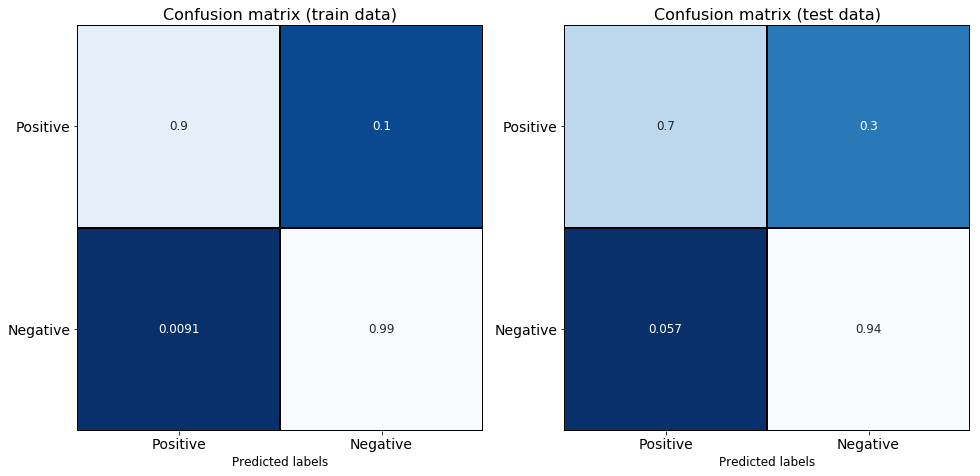

In [32]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

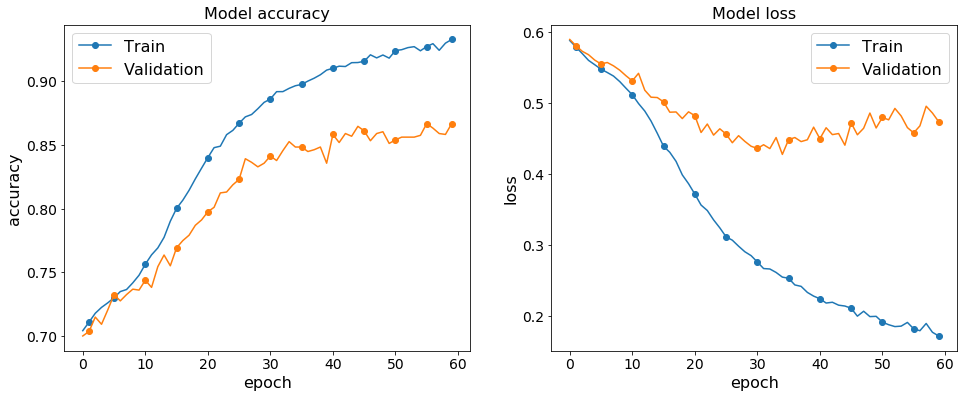

In [33]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

markers_on = [1,5,10,15,20,25,30,35,40,45,50,55,59]

# History of accuracy
axis1.plot(history.history['acc'], label='Train',marker='o',markevery=markers_on)
axis1.plot(history.history['val_acc'], label='Validation',marker='o',markevery=markers_on)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# History of loss
axis2.plot(history.history['loss'], label='Train',marker='o',markevery=markers_on)
axis2.plot(history.history['val_loss'], label='Validation',marker='o',markevery=markers_on)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [35]:
# Save Models for APIs
from keras.models import model_from_json
model_json = model.to_json()
with open("Consumermodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Consumermodel.h5")
bigrams_model.save("Bigram_Word2VecModel2.model")

D:\Anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
